In [9]:
from notebook import *

#KEY include Namebox.ipynb

<div class="title">Lab 2: The Compiler</div>

# OUtline

#KEY delete cell

1. C++
    1. CFGs
        1.  if-else if-else if-...
        2.  Loops
        3.  composed
    2. Call graphs -- examples of simple programs
        1.  GPROF
        2.  
    3.  Looking at assembly
    4. Optimizations
        2.  Register assignment
        3.  common sub-expression elimination
        4.  invariant code motion
        5.  Strength reduction.
        6.  Constant propagation
        7.  Loop unrolling // Defer until ILP/MLP
        8.  Function inlining
            1. The cost of a function call.
            2. CFG impact.
            3. Constant propagation impact
        9.  Combining it all:  C++ and the STL.
            1.  The importance of optimization in C++
        10. Ways to poke the compiler
            1.  register
            2.  volatile
    5. Programming assignment -- beat the compiler
        1.  Given a piece of code, can you beat the compiler?
        2.  Maximize _average speedup_ across dataset sizes for `sum_of_locations`.
2. Python
    1.  It's slow.
        1.  Measure overall performance of python vs C++ implementations
        2.  Optimizations don't help?
        3.  Amdahl's Law analysis of python startup time?
3. Javascript
    1.  Also slow
        1.  Measure overall performance of python vs C++ implementations
        2.  Optimizations don't help?
        3.  Amdahl's Law analysis of python startup time?
    2. But there's a JIT


This lab will give you a much clearer understanding of the role that the compiler plays in translating your source code into executables.  Our focus is on the optimizations that the compiler performs and the critical role that they play in efficiently implementing modern compiled programming languages (e.g., C, C++, Rust, Go, and Java).  We will use C++, but many of the same lessons apply to other languages.

This lab includes a programming assignment.  You should start thinking about it early, so read that section now.

Check the course schedule for due date(s).

# FAQ and Updates

* There are no updates, yet.

 #KEY include about.ipynb

 #KEY include Login-key.ipynb

# Grading

Your grade for this lab will be based on the following components.

| Part                       | value |
|----------------------------|-------|
| Reading quiz               | 3%    |
| Jupyter Notebook           | 70%   |
| Programming Assignment     | 25%   |
| Post-lab survey.           | 2%    |

No late work or extensions will be allowed.

We will grade 5 of the "completeness" problems.  They are worth 3 points each.  We will grade all of the "correctness" questions.

You'll follow the directions at the end of the lab to submit the lab write up and the programming assignment through gradescope. 

Please check gradescope for exact due dates.

# A Note About The Examples

There are a bunch of short functions in the examples in the lab.  Their purpose is to illustrate the impact of different compiler optimizations in a clear way, and that is what I designed them for (often by trial and error).  As a result, none of them do anything _useful_.   Please don't expend effort trying to understand what the functions are doing or what they are for, there's nothing to find :-).

If you look closely, you'll also see that I compile some of the functions using complex sets of compiler flags.  I do this highlight specific optimizations, but it's not usually helpful or necessary.
GCC and other compilers provide a [huge number of flags](https://gcc.gnu.org/onlinedocs/gcc/Optimize-Options.html) that control how the compiler optimizes.  Using these flags is _almost never necessary_ in the real world.  When you need to ship your code, just compile it with `-O3`.



# Common Errors

<div class="alert alert-block alert-danger">

**Known (but harmless) Bug** There's a known, intermittent bug in the CFG generation tool.  IF you get this error:
    
```
^
Expected {'graph' | 'digraph'}  (at char 0), (line:1, col:1)
```
    
</div>

Just run the cell again (several times if needed), and it will eventually work.

# New Tools

There are few new tools we will be using in this lab.

## Fiddles

This lab includes some "fiddles" that allow you to write C++ code and then analyze and/or run it.  Here's an example that runs the program then shows you the assembly for `main()` (give it a try):

In [2]:
fiddle("hello_fiddle.cpp", function="main", run=False, code=r"""
#include<iostream>
int main(int argc, char * argv[]) {
    std::cout << "hello world!\n";
    return 0;
}
""").asm

Compiling your code...
rm -f build/hello_fiddle.s hello_fiddle.exe build/hello_fiddle.o

make build/hello_fiddle.s hello_fiddle.exe C_OPTS='' 
cat: short_name: No such file or directory
cat: short_name: No such file or directory
mkdir -p build/
cp hello_fiddle.cpp build/hello_fiddle.cpp 
g++-8 -S -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/hello_fiddle.cpp -o build/hello_fiddle.s
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/hello_fiddle.cpp -o build/hello_fiddle.o
g++-8 build/hello_fi

; build/hello_fiddle.s:15-34 (20 lines)
main:
.LFB1463:
	.cfi_startproc
	pushq	%rbp
	.cfi_def_cfa_offset 16
	.cfi_offset 6, -16
	movq	%rsp, %rbp
	.cfi_def_cfa_register 6
	subq	$16, %rsp
	movl	%edi, -4(%rbp)
	movq	%rsi, -16(%rbp)
	leaq	.LC0(%rip), %rsi
	movq	std::cout@GOTPCREL(%rip), %rax
	movq	%rax, %rdi
	call	std::basic_ostream<char, std::char_traits<char> >& std::operator<< <std::char_traits<char> >(std::basic_ostream<char, std::char_traits<char> >&, char const*)@PLT
	movl	$0, %eax
	leave
	.cfi_def_cfa 7, 8
	ret
	.cfi_endproc

## Control Flow Graphs

Control flow graphs (CFGs) are a common way to visually inspect the structure of _one function_ in a program.  

A CFG is a collection of nodes and edges.  Each node is a _basic blocks_ -- a sequence of instructions that always execute together.  This means that a basic block ends with either 1) a branch, 2) a jump, or 3) the target of a branch or jump.  The edges in the CFG are possible _control transfers_ between basic blocks.  So, the CFG shows all possible paths of control flow through the function.

Take a look at this code (shift-return to render it):

Compiling your code...
rm -f build/if_ex.s if_ex.exe build/if_ex.o

make build/if_ex.s if_ex.exe C_OPTS='' 
cat: short_name: No such file or directory
cat: short_name: No such file or directory
mkdir -p build/
cp if_ex.cpp build/if_ex.cpp 
g++-8 -S -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/if_ex.cpp -o build/if_ex.s
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/if_ex.cpp -o build/if_ex.o
g++-8 build/if_ex.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchl

// if_ex.cpp:6-12 (7 lines)
uint64_t * if_ex(uint64_t * array,
		 unsigned long int size) {
	if (size == 0) {
		return NULL;
	}
	return array;
}

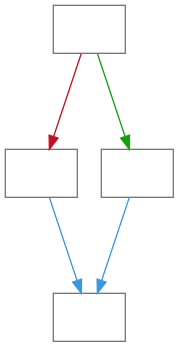

In [3]:
t = fiddle("if_ex.cpp", function="if_ex", run=False, remove_assembly=True, code=r"""
#include<cstdint>
#include<cstdlib>

extern "C" 
uint64_t * if_ex(uint64_t * array,
		 unsigned long int size) {
	if (size == 0) {
		return NULL;
	}
	return array;
}

int main() {
}
""")
display(t.source)
display(t.cfg)


The CFG shows that there are two paths through the function depending on the value of the `if` condition.  So there are two paths along which _control_ can _flow_.

Here's a more complex piece of code (below the question).  Study it, answer the question, and then run the code cell below.

<div class="question completeness">

<div class="question-text">What do you think the CFG for the code below will look like (describe it briefly or use ASCII art or paste in screen capture)?</div>

<div class="answer">

```
ASCII art or text drawing/description of the CFG here.
    
```
    
**How many paths through the code are there?**



Or paste an image out here (outside the triple backticks).

</div>
</div>

Compiling your code...
rm -f build/if_else_if_else.s if_else_if_else.exe build/if_else_if_else.o

make build/if_else_if_else.s if_else_if_else.exe C_OPTS='' 
cat: short_name: No such file or directory
cat: short_name: No such file or directory
mkdir -p build/
cp if_else_if_else.cpp build/if_else_if_else.cpp 
g++-8 -S -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/if_else_if_else.cpp -o build/if_else_if_else.s
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/if_else_if_else.cpp -o build/if_el

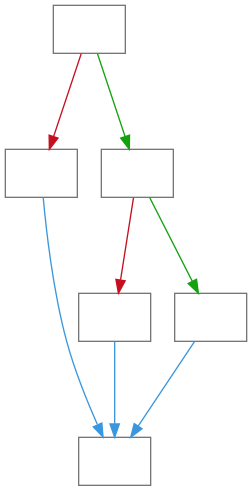

In [4]:
t = fiddle("if_else_if_else.cpp", function="if_else_if_else", remove_assembly=True, run=False, code=r"""
#include<cstdint>
#include<cstdlib>

extern "C" 
uint64_t * if_else_if_else(uint64_t * array,
			   unsigned long int size) {
	if (size/2) {
		return NULL;
	} else if (size/3) {
		return &array[size/3];
	} else {
		return array;
	}
}

int main() {
}
""")
display(t.cfg)

<div class="question correctness points-4">
    
#### In the fiddle below, modify `foo()` so that its CFG looks like this (you can edit the code as many times as you'd like):

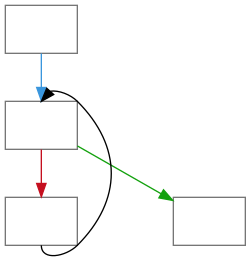

</div>

Compiling your code...
rm -f build/mimic_1.s mimic_1.exe build/mimic_1.o

make build/mimic_1.s mimic_1.exe C_OPTS='' 
cat: short_name: No such file or directory
cat: short_name: No such file or directory
mkdir -p build/
cp mimic_1.cpp build/mimic_1.cpp 
g++-8 -S -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/mimic_1.cpp -o build/mimic_1.s
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/mimic_1.cpp -o build/mimic_1.o
g++-8 build/mimic_1.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-ar

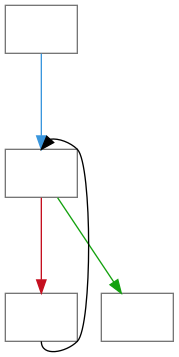

In [5]:
#KEY answer_cell
fiddle("mimic_1.cpp", "foo",code="""
extern "C"
int foo(int a);

int main(int argc, char * argv[]) {
    return foo(4);
}

extern "C" 
int foo(int a) {
    int s = 0;                    //KEY delete_line
    for(int i = 0; i < 10; i++) { //KEY delete_line
        s += 1;                   //KEY delete_line
    }                             //KEY delete_line
    return 0;
}

""", remove_assembly=True, run=False).cfg

Finally, take a look at this code and the resulting CFG.:

Compiling your code...
rm -f build/loop_if.s loop_if.exe build/loop_if.o

make build/loop_if.s loop_if.exe C_OPTS='' 
cat: short_name: No such file or directory
cat: short_name: No such file or directory
mkdir -p build/
cp loop_if.cpp build/loop_if.cpp 
g++-8 -S -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/loop_if.cpp -o build/loop_if.s
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/loop_if.cpp -o build/loop_if.o
g++-8 build/loop_if.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-ar


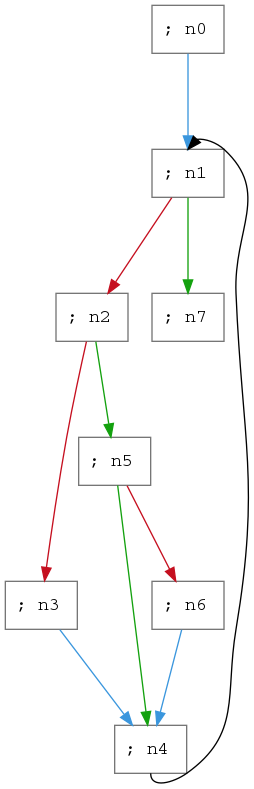

In [6]:
t = fiddle("loop_if.cpp", function="loop_if", number_nodes=True, run=False, remove_assembly=True, code=r"""
#include<cstdint>
#include<cstdlib>

extern "C" 
uint64_t * loop_if(uint64_t * array,
		   unsigned long int size) {
	uint64_t* t= NULL;
	int k = 0;
	for(uint i = 0; i < size; i++) {
		if (i-size != 0) {
			k = 4;   //  L1
		} else if (i+size != 0) { // L2
			k = 5;
		}
	}
	return t + k; // L3
	
}


int main() {
}
""")
compare([t.source, t.cfg])


<div class="question correctness points-3">
    
<div class="question-text">Fill out the table below to show which nodes in the CFG correspond to the labeled line in the source code:</div>
    
<div class="answer">

| Line | Node | 
|------|------|
| L1   |       #KEY N3 |
| L2   |       #KEY N5 |
| L3   |       #KEY N7 |
    
</div>
</div>

## Call Graphs

CFGs shows the control flow _within a single function_ , but they cannot tell us much about the flow of control through an entire program.  To understand how functions call one another, we will use _call graphs_.

In a call graph, the nodes are functions, and an edge exists from one function to another, if the first function calls the second.

We will build call graphs by running the programming and keeping track of which function calls occur.  We'll use the `gprof` profiler to collect the data, which means that building a call graph is a three stop process:

1.  Compile the program with `gprof` enabled.
2.  Run the program on a representative input.
3.  Generate the call graph for that execution of the program.

Take a look at the code in the fiddle below and think about what the call graph might look like.  Then run it and see if it matches your intuition.

Compiling your code...
rm -f build/cg1.s cg1.exe build/cg1.o

make build/cg1.s cg1.exe C_OPTS='' GPROF=yes
mkdir -p build/
cp cg1.cpp build/cg1.cpp 
g++-8 -S -c -Wall -Werror -g   -pg   -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/cg1.cpp -o build/cg1.s
gcc-8 -c -Wall -Werror -g   -pg   -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/cg1.cpp -o build/cg1.o
g++-8 build/cg1.o   -pg -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -lboost_program_options -lm -lquadmath -ldl    -o cg1.exe

Running your code...
./

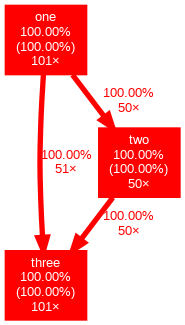

In [5]:
#KEY answer_cell
fiddle("cg1.cpp", gprof=True, function="one", code="""
extern "C" {
int one(int a);
int two(int a);
int three(int a);

int main(int argc, char * argv[]) {
    for(int i = 0; i < 100; i++) one(i);
    return one(4);
}

int one(int a) {
    if (a & 1)
        return two(a);
    else
        return three(a);
}

int two(int a) {
    return three(a);
}

int three(int a) {
    return a;
}
}
""", remove_assembly=True).call_graph


The call graph has a bunch of information in it regarding how many times each function was called and how often a function was called from one location rather than another, but for now, we'll just focus on which function called which.

<div class="question completeness">

<div class="question-text">Modify the fiddle above to add a loop to the call graph (but be sure the function still terminates).  Describe what you did below.</div>

<div class="answer">
    #KEY Should match their code and their code should do what it needs to
</div>
<div>
   

Call graphs can reveal the internal workings of libraries that use routinely.  For instance, Take a look at the function below.

<div class="question completeness">

<div class="question-text">How deep do you think the call graph is (i.e., how long is the longest chain of one function calling another, calling another, etc.)?  How many different functions do you think are invoked? How many function calls are made?</div>
    
<div class="answer">

1. How deep is the graph?:

2. How many different functions are called?:
    
3. How many function calls are made?

</div>

</div>


In [6]:
t = fiddle("fiddle_sort.cpp", gprof=True, function="one", opt="-O0", code="""
#include<algorithm>

extern "C" int one(int a);

int main(int argc, char * argv[]) {
    return one(4);
}
#define ARRAY_SIZE (16*1024)
extern "C"  int one(int a) {
    int * array = new int[ARRAY_SIZE];
    std::sort(array, &array[ARRAY_SIZE]);
    return array[a];
}

""", remove_assembly=False,  trim_addresses=True, trim_comments=True)

Compiling your code...
rm -f build/fiddle_sort.s fiddle_sort.exe build/fiddle_sort.o

make build/fiddle_sort.s fiddle_sort.exe C_OPTS='-O0' GPROF=yes
mkdir -p build/
cp fiddle_sort.cpp build/fiddle_sort.cpp 
g++-8 -S -c -Wall -Werror -g  -O0 -pg   -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/fiddle_sort.cpp -o build/fiddle_sort.s
gcc-8 -c -Wall -Werror -g  -O0 -pg   -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/fiddle_sort.cpp -o build/fiddle_sort.o
g++-8 build/fiddle_sort.o   -pg -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libar

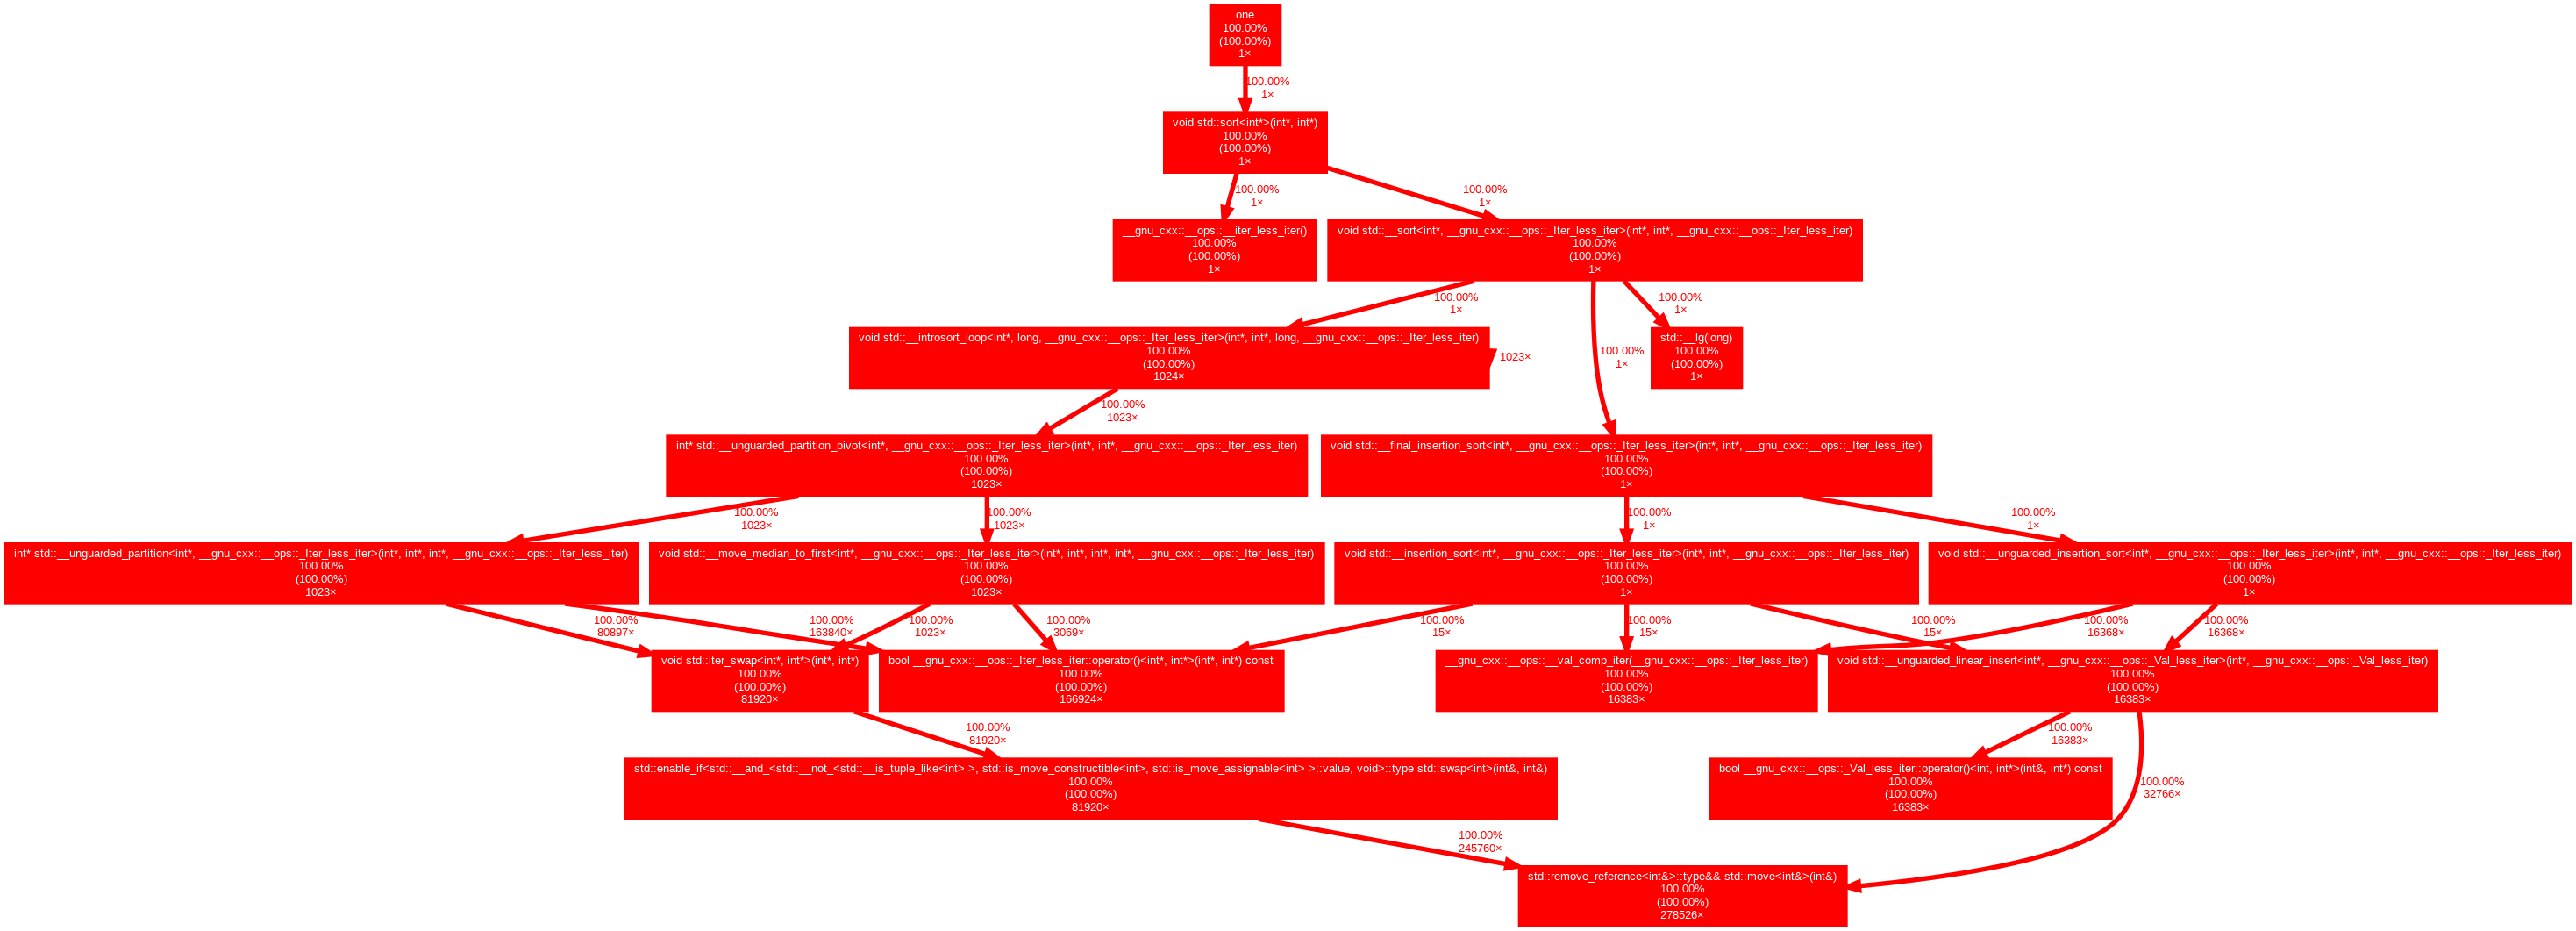

In [7]:
display(t.call_graph)

Wow, what a mess!  

You can double click on the image to zoom in and pan around.  You'll see lots of functions called many, many times, and each of those function calls requires a few extra instructions (e.g., to call the function and return from it.)

This seems shockingly inefficient.  Someone should really clean that up!

This kind of complex, deep call graph is very common in modern object-oriented programming languages.  

<div class="question optional">
<div class="question-text">
If you're curious, modify the fiddle to use other parts of the STL.  For instance, could create and initialize a `std::vector`  or an `std::list`.
</div>
<div class="answer">
What did you find?
</div>
</div>

## Looking At Assembly

CFGs and call graphs are good tools for looking at the high-level structure and behavior of programs, but we also need to understand what's going on at a finer level:  Inside the basic blocks.  To do that, we'll have to look at the assembly language that the compiler generates.

The lectures in 142 provided an overview of the x86 assembly and our main goal in both courses is that you be able to look at some x86 assembly and (with the help of google) get _some idea_ of what is going on.

<div class="alert alert-block alert-danger">

**Use the Slides, Luke! (and google!):** This lab doesn't contain everything you need to know about x86 assembly.  Please look back over the slides from 142 and relevant parts of the text book for more details, especially about function suffixes and the register file.  Google is good resource as well searching for "x86 _inst name_ " will get your information about any instruction.
</div>

### The Basics

We'll start simple by revisiting the `if_ex()` function we saw earlier:

Compiling your code...
rm -f build/if_ex.s if_ex.exe build/if_ex.o

make build/if_ex.s if_ex.exe C_OPTS='' 
mkdir -p build/
cp if_ex.cpp build/if_ex.cpp 
g++-8 -S -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/if_ex.cpp -o build/if_ex.s
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/if_ex.cpp -o build/if_ex.o
g++-8 build/if_ex.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -lboost_program_options -lm -lquadmath -ldl    -o if_ex.exe



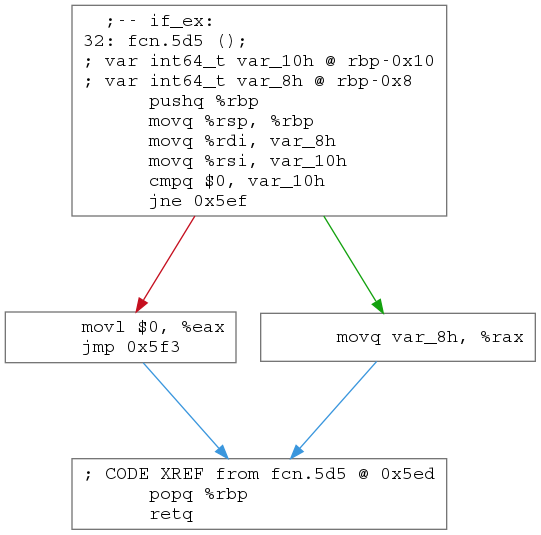

In [8]:
t = fiddle("if_ex.cpp", function="if_ex", run=False, code=r"""
#include<cstdint>
#include<cstdlib>

extern "C" 
uint64_t * if_ex(uint64_t * array,
		 unsigned long int size) {
	if (size == 0) {
		return NULL;
	}
	return array;
}

int main() {
}
""")
compare([t.source, t.asm])
display(t.cfg)

Take some time to study the source code (top left) and assembly output (top right) and how it corresponds to the CFG annotated with the assembly.

A few things to note:

1.  Comments in assembly start with `;`
2.  Things like `.L7:` that end in `:` are labels in the assembly and can be used as the "targets" of branches.  Some of them (e.g., `if_ex`) mark the beginnings of functions.
3.  Other things like `.cfi_endproc` are assemble directives.  We will mostly ignore them.

Finally, note how the assembly in the CFG is different than the assembly from the compiler. 

The assembly on the right is the actual x86 assembly that the compiler generated.  The code in the CFG is equivalent, but it's not x86 assembly.  We'll call it _pseudo-assembly_.  There's a one-to-one correspondence between the assembly and the pseudo-assembly but there are some important differences:

1.  The targets from branch and jump instructions are raw addresses in the pseudo-assembly rather than labels.
2.  The pseudo-assembly provides some information about argument types in comments (e.g., `; var int64_t var_10h @ rbp-0x10`) and then uses `var_10h` in the assembly.  

You should also be able to spot the boundaries between the basic blocks in the assembly and see how the CFG makes them explicit.  You can see that the instruction at the start of each basic block is either

1. A branch target (I.e., a label that a branch might jump to), or
2. The instruction right after a branch.

The last instruction in each basic block is either:

1.  The instruction before a branch target (i.e.,  label), or
2.  A branch, jump, or return instruction.


<div class="question completeness">

<div class="question-text"> 
    
How does the variable `size` appear in the assembly and the pseudo-assembly?  That is, how can we tell that an instruction is operating on the value store in `size`?
</div>
    
<div class="answer">

1. What does `size` look like in x86 assembly: #KEY -16(%rbp).
2. What does `size` look like in pseudo-assembly: #KEY [var_10h]
3. How can you tell which instruction it is?  #KEY it's compared to 0
    
</div>    
</div>    

### A More Complex Example

Here's the assembly for `loop_if()`.

Compiling your code...
rm -f build/loop_if.s loop_if.exe build/loop_if.o

make build/loop_if.s loop_if.exe C_OPTS='' 
mkdir -p build/
cp loop_if.cpp build/loop_if.cpp 
g++-8 -S -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/loop_if.cpp -o build/loop_if.s
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/loop_if.cpp -o build/loop_if.o
g++-8 build/loop_if.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -lboost_program_options -lm -lquadmath -ldl    -o lo

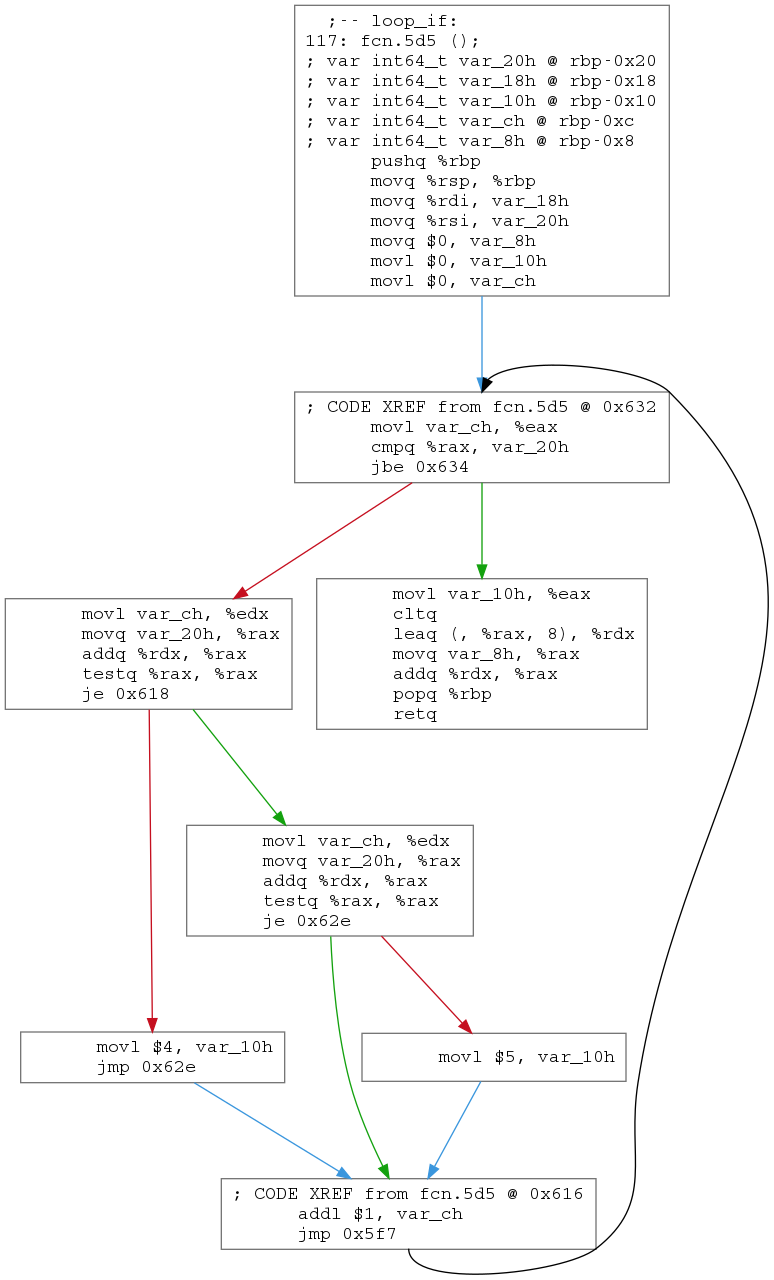

In [9]:
t = fiddle("loop_if.cpp", function="loop_if", run=False, code=r"""
#include<cstdint>
#include<cstdlib>

extern "C" 
uint64_t * loop_if(uint64_t * array,
		   unsigned long int size) {
	uint64_t* t= NULL;
	int k = 0;
	for(uint i = 0; i < size; i++) {
		if (i  + size != 0) { //  L1
			k = 4; 
		} else if (i+size != 0) { // L2
			k = 5;
		}
	}
	return t + k; // L3
	
}


int main() {
}
""")
compare([t.source, t.asm])
display(t.cfg)

<div class="question correctness points-2">

<div class="question-text">

What instruction implements these parts of the `loop_if()` (just copy and paste it from the assembly and don't be afraid to google.)?

</div>
        
<div class="answer">

|    |  Instruction|
|------|------|
| The add on line `L1` |  #KEY 	addq	%rdx, %rax | 
| The comparison to zero on line `L2` | #KEY 	testq	%rax, %rax |  
    
</div>    
</div>    

### Counting Instructions With the CFG

In the next section you will study how compiler optimizations change which instructions execute.  Let's see what we can learn about which instructions execute from by looking at the assembly.

Compiling your code...
rm -f build/loop_func.s loop_func.exe build/loop_func.o

make build/loop_func.s loop_func.exe C_OPTS='' 
mkdir -p build/
cp loop_func.cpp build/loop_func.cpp 
g++-8 -S -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/loop_func.cpp -o build/loop_func.s
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/loop_func.cpp -o build/loop_func.o
g++-8 build/loop_func.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -lboost_program_options -lm 

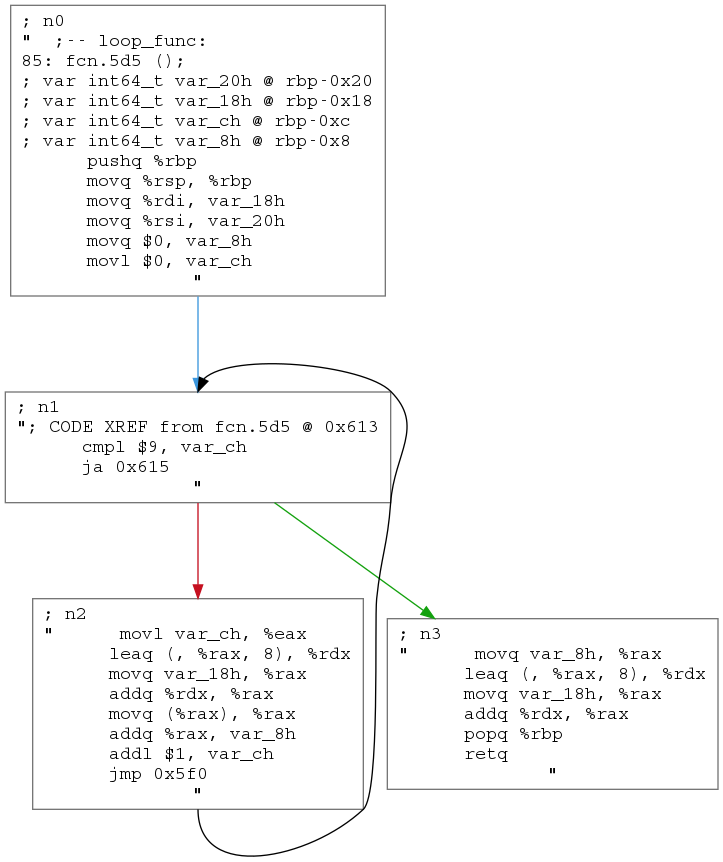

In [12]:
t = fiddle("loop_func.cpp", function="loop_func", number_nodes=True, run=False, code=r"""
#include<cstdint>
#include<cstdlib>

extern "C" 
uint64_t * loop_func(uint64_t * array,
		      unsigned long int size) {

	uint64_t s = 0;
	for(uint i = 0; i < 10; i++) {
		s += array[i];
	}
	return &array[s];
	
}


int main() {
}
""")
compare([t.source, t.asm])
display(t.cfg)

Are primarily interested in two things:

1.  How many instructions execute _in total_ (that's just `IC` from the performance equation).
2.  How many instructions access memory.

Counting instructions is simple:  You can count up the number of instructions in each basic block and multiply it by the number of times the basic block executes.

Determining which instructions access memory is also simple except for one wrinkle.

The basic rule is that:

1.  In x86 assembly, if the instruction uses an addressing mode with parentheses (e.g., `-8(%rbp)` or `(%rax)`) then it accesses memory.
2.  In pseudo-assembly, operands like `[var_8h]` or `[rax*8]` are also memory accesses.

The exception is the `lea` family of instructions (`leaq`, `leal`, etc.). These are "load effective address" and they just compute the address and store the _address_ into into the destination register.  So when you count memory accesses you should ignore `lea*` instructions.

<div class="question completeness">

<div class="question-text">
    
Fill in the table below to compute how many total instructions and how many memory accesses occur when `loop_func()` executes (Hint:  It is not necessary to trace through exactly what each instruction does.  Instead think about how control will flow through the CFG and just count how many times each block must execute.  Also don't be afraid to google the instruction names.).
    </div>
    
<div class="answer">

| basic block | execution count | static instruction count | static memory instruction count |  dynamic insturction count | dynamic memory instruction count | 
|-------------|-----------------|-------------------|--------------------------|-------------------|--------------------------|
| n0          |  #KEY           1    |      5             | 3                         | 5 |3|
| n1          |   #KEY        11      |       2            | 1                         |22 |11|
| n2          |   #KEY      10        |      8             |  5                        |80 |50|
| n3          |   #KEY      1        |      5             |    2                      | 5|2|
|                 |                ||   **Total**    #KEY                           |112|66 | 
    
</div>

# The Perils of C++

C++ is a big, complex mess of a language that includes a bunch of powerful tools that make it possible to write fast code without too much pain.  However, all that power translates into a lot of complexity that shows up in the assembly code generated for C++ programs.  

In order to read C++ assembly output, you need to understand a few details of how linking works.

## What Is Linking?

Linking the final step in compiling a program.  Non-trivial programs are spread across multiple source files that are compiled one-at-a-time into _object files_ (`.o`) that contain binary instructions and static data (e.g., string constants from your code).  Each function and global variable in the object file has a name called a _symbol_.  We say that the object file _defines_ the symbols it contains.  For instance, if `foo.cpp` contains the source code for a function `bar()` then, `foo.o` will define the symbol `bar`.

The code in the object files will also _reference_ symbols defined in other object files.  For instance, if another file, `baz.cpp`, calls `bar`, then `baz.o` will have reference to `bar`.  Prior to linking that reference is _undefined_.

The linker takes all the `.o` files and copies into a single executable file.  As it copies them it _resolves_ the undefined references.  In 
this example, the linker resolves the undefined reference in `bar.o`  by replacing the reference with pointer to the code for `bar()` in  `foo.o`.

One important thing about linkers is that they are language-agnostic -- the linker will happy link object file generated from C++, C, Go, or Rust as long as the symbols match.

There's a lot more to [linking](https://www.amazon.com/Linkers-Kaufmann-Software-Engineering-Programming/dp/1558604960), but this is enough to see what's problematic about C++.

## C++ Name Mangling

The linker restricts what strings can server as valid symbols: Symbols must start with a letter (or `_`) and only contain letters, numbers, and `_`.

For C, this poses no problems. If you declare a function `bar` in file `foo.c`:

``` c++
int bar(int a) {
    return 1;
}
```

The compiler will generate exactly one symbol with the name `bar`.   Then you can call it from another file `baz.c`:

```  c++
main() {
     bar(4);
} 
```

and the linker will know what function you mean (i.e., the function named `bar` from `foo.c`).

However, C++ allows function overloading, so we might have this in `foo.cpp`:

``` c++
int bar(int a) {
}

float bar(float a) {
}

```

This will generate two functions, so they need two symbols.  But what symbols should the compiler choose?  The compiler needs a systematic way of naming functions _that includes their type information_.  This will ensure that when we have `baz.cpp`

``` c++
main() {
    bar(4);
    bar(4.0);
} 
```

The linker will know that we mean to call two different functions.

Things get more complex with templates, since we could have:

``` c++
int bar(const std::map<std::string, std::vector<int>> & a) {
}
```

That's a lot of information to pack into one symbol!

The solution that C++ compilers have adopted is called _name mangling_.  Name mangling is a deterministic, standardized way to convert _any_ global variable or function type and name and type into a unique symbol.

Let's see what it does.  Run the fiddle and answer the question:

In [14]:
fiddle("mangle.cpp", function="", demangle=False, code="""
#include<map>
#include<vector>
#include<string>
int foo(int a) {
    return 0;
}

float foo(float a) {
    return 0;
}

int foo(const std::map<std::string, std::vector<int>> & a) {
    return 0;
}

int main(){}
""").asm

Compiling your code...
rm -f build/mangle.s mangle.exe build/mangle.o

make build/mangle.s mangle.exe C_OPTS='' 
mkdir -p build/
cp mangle.cpp build/mangle.cpp 
g++-8 -S -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/mangle.cpp -o build/mangle.s
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/mangle.cpp -o build/mangle.o
g++-8 build/mangle.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -lboost_program_options -lm -lquadmath -ldl    -o mangle.exe

Ru

; build/mangle.s:1-90 (90 lines)
	.file	"mangle.cpp"
	.text
	.section	.rodata
	.type	_ZStL19piecewise_construct, @object
	.size	_ZStL19piecewise_construct, 1
_ZStL19piecewise_construct:
	.zero	1
	.type	_ZStL13allocator_arg, @object
	.size	_ZStL13allocator_arg, 1
_ZStL13allocator_arg:
	.zero	1
	.type	_ZStL6ignore, @object
	.size	_ZStL6ignore, 1
_ZStL6ignore:
	.zero	1
	.text
	.globl	_Z3fooi
	.type	_Z3fooi, @function
_Z3fooi:
.LFB1841:
	.cfi_startproc
	pushq	%rbp
	.cfi_def_cfa_offset 16
	.cfi_offset 6, -16
	movq	%rsp, %rbp
	.cfi_def_cfa_register 6
	movl	%edi, -4(%rbp)
	movl	$0, %eax
	popq	%rbp
	.cfi_def_cfa 7, 8
	ret
	.cfi_endproc
.LFE1841:
	.size	_Z3fooi, .-_Z3fooi
	.globl	_Z3foof
	.type	_Z3foof, @function
_Z3foof:
.LFB1842:
	.cfi_startproc
	pushq	%rbp
	.cfi_def_cfa_offset 16
	.cfi_offset 6, -16
	movq	%rsp, %rbp
	.cfi_def_cfa_register 6
	movss	%xmm0, -4(%rbp)
	pxor	%xmm0, %xmm0
	popq	%rbp
	.cfi_def_cfa 7, 8
	ret
	.cfi_endproc
.LFE1842:
	.size	_Z3foof, .-_Z3foof
	.globl	_Z3fooRKSt3mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESt6vectorIiSaIiEESt4lessIS5_ESaISt4pairIKS5_S8_EEE
	.type	_Z3fooRKSt3mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESt6vectorIiSaIiEESt4lessIS5_ESaISt4pairIKS5_S8_EEE, @function
_Z3fooRKSt3mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESt6vectorIiSaIiEESt4lessIS5_ESaISt4pairIKS5_S8_EEE:
.LFB1843:
	.cfi_startproc
	pushq	%rbp
	.cfi_def_cfa_offset 16
	.cfi_offset 6, -16
	movq	%rsp, %rbp
	.cfi_def_cfa_register 6
	movq	%rdi, -8(%rbp)
	movl	$0, %eax
	popq	%rbp
	.cfi_def_cfa 7, 8
	ret
	.cfi_endproc
.LFE1843:
	.size	_Z3fooRKSt3mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESt6vectorIiSaIiEESt4lessIS5_ESaISt4pairIKS5_S8_EEE, .-_Z3fooRKSt3mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESt6vectorIiSaIiEESt4lessIS5_ESaISt4pairIKS5_S8_EEE
	.globl	main
	.type	main, @function
main:
.LFB1844:
	.cfi_startproc
	pushq	%rbp
	.cfi_def_cfa_offset 16
	.cfi_offset 6, -16
	movq	%rsp, %rbp
	.cfi_def_cfa_register 6
	movl	$0, %eax
	popq	%rbp
	.cfi_def_cfa 7, 8
	ret
	.cfi_endproc
.LFE1844:
	.size	main, .-main
	.ident	"GCC: (Ubuntu 8.4.0-1ubuntu1~18.04) 8.4.0"
	.section	.note.GNU-stack,"",@progbits

<div class="question completeness">

<div class="question-text"> What's the mangled name for each of these functions?</div>
    
<div class="answer">
    
| function | mangled name |
|----------|--------------|
| `int foo(int a)` | | 
| `float foo(float a)` |  | 
| `int foo(const std::map<std::string, std::vector<int>> & a)`| |

    
</div>

</div>

As you can see, mangled names make assembly pretty hard to read. To make matters worse, mangled names show up in other places as well (e.g.,  the output of profiling tools).

Fortunately, C++ compilers usually come with a utility to de-mangle names.  For `g++` it's called `c++filt` and it takes in text, looks for mangled names and demangles them.  For instance:

In [15]:
!echo _Z3foof | c++filt
!echo _Z3fooRKSt3mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESt6vectorIiSaIiEESt4lessIS5_ESaISt4pairIKS5_S8_EEE | c++filt

foo(float)
foo(std::map<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::vector<int, std::allocator<int> >, std::less<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > >, std::allocator<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const, std::vector<int, std::allocator<int> > > > > const&)


You'll notice that the full name for `int foo(const std::map<std::string, std::vector<int>> & a)` is very long.  This is because it includes full type names (including the C++ namespace) and all the default template parameters.

To see how it works on assembly, change `demangle=False` in the fiddle above to `demangle=True` and re-run it.  The resulting assembly is no longer valid code (since the symbol names are invalid), but it's much easier to read.

From now on in the examples, the assembly code in the examples will be demangled, but you will probably run into some mangled names occasionally.  Just remember to use `c++filt` to clean them up.

## C vs C++ Linkage

The way that the compiler generate symbols for a function is called the function's _linkage_.  We've seen two kinds:  C linkage which just uses the function name  and C++ linkage which uses mangled names.

You might have noticed that some of the code examples have `extern "C"` before some functions.  This is a way of telling the compiler that it should use C linkage for those functions (i.e., just use the function names).  You can use it for one function:

``` c++
extern "C" int foo()
```

or a group of functions:

``` c++
extern "C" {
    int foo(){}
    int bar(){}
}
```

This is useful if you want to call the function from a language other than C++ (e.g., C).  We will use it in the examples, because it makes it easier to refer to the functions.


# Optimization

Now, we have all the tools we need to study how  compiler optimizations affect program performance.  In the exercises below, we'll look at some of the most important optimizations that compilers perform and why and how they work.  

We have several goals:

1.  To provide some intuition about what the compiler can and cannot do, so you can predict when it will need your help and when you should trust it to "do the right thing".
2.  To see how and why optimization is so important for languages like C++.
3.  To gain further insight into how a computation is implemented affects performance (via the performance equation).

## Register assignment

The first and simplest optimization is _register assignment_.  You can see it in action below:

In [16]:
unopt = fiddle("reg_assign.cpp", function="foo", run=False, code="""

extern "C" int foo(int a, int b){
    return a * b;
}

int main(){
    return foo(1, 0);
}
""")
opt = fiddle("reg_assign.cpp", function="foo", run=False, opt="-O1")
display(unopt.source)
compare([unopt.asm, opt.asm], ["Unoptimized", "Optimized (-O1)"])

Compiling your code...
rm -f build/reg_assign.s reg_assign.exe build/reg_assign.o

make build/reg_assign.s reg_assign.exe C_OPTS='' 
mkdir -p build/
cp reg_assign.cpp build/reg_assign.cpp 
g++-8 -S -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/reg_assign.cpp -o build/reg_assign.s
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/reg_assign.cpp -o build/reg_assign.o
g++-8 build/reg_assign.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -lboost_program_

// reg_assign.cpp:3-5 (3 lines)
extern "C" int foo(int a, int b){
    return a * b;
}

Wow!  The optimized code is much shorter!

A few things to notice about the code and to remember about x86 assembly:

First, the "base pointer" is in `%rbp`.  This is the base of the stack frame for this function call.  Local variables typically live on the stack and are accessed relative to the base pointer.

Second, in x86, the first two function arguments are passed in `%edi` and `%esi`.  Return values are stored in `%eax`.

Third, in unoptimized code, `a` and `b` are on the stack at locations `-4(%rbp)` and `-8(%rbp)`, respectively.  In fact, the compiler goes through the trouble of storing `%edi` and `%esi` into `-4(%rbp)` and `-8(%rbp)`.  

Then it, _immediately_ uses `movl` to load `a` back into the `%eax` before the `imull` instruction loads `b` from the stack, multiplies it by `%eax`, storing the result in `%eax`. 

The optimized code avoids all that nonsense with the stack.  It just copies `%edi` into `%eax`, and multiplies it by `%esi`, once again leaving the result in `%eax`.

<div class="alert alert-block alert-info">

**Pro Tip: Identifying unoptimized assembly** Register assignment is one of the most basic optimizations that compilers preform and the difference between the optimized and unoptimized versions is starkly obvious.  This means that you can usually just tell by looking at assembly code whether it was compiled with optimizations enabled.
</div>

<div class="question correctness points-2">

<div class="question-text">
    
Assuming constant `CPI` and `CT` how much speedup will did register assignment provide for `foo()` (show your work)?
    
</div>
 
<div class="answer">
    
#KEY unopt_IC = 8; opt_IC = 3;  Speedup = 8/3 = 2.66x
    
</div>

    
</div>

You can also encourage the compiler to put a variable into a register with `register` keyword.  This is not a good practice in real code since modern compilers do register assignment automatically.  We'll use this trick in some of our examples to highlight the impact of individual optimizations.  

<div class="question completeness">
    

<div class="question-text">

Go ahead and try it on the fiddle above by writing `register int a` in the argument list for `foo()`.  What changed?
</div>
    
<div class="answer">
    
#KEY 	movl	%edi, %eax instead of  	movl	%edi, -4(%rbp)
    
</div>
    
</div>

## Common sub-expression elimination

A _common sub-expression_ is a piece of repeated computation in a program.  Since calculating the same thing twice is a waste of time, the compiler will eliminate the second instance and reuse the result of the first.  Here's an example:

In [17]:
#KEY answer_cell
unopt = fiddle("CSE.cpp", function="foo", run=False, code="""

extern "C" int foo(register int a, register int b){
   register int c = a * b;
   return a * b + c;
}

int main(){
    return foo(1, 0);
}
""")
opt = fiddle("CSE.cpp", function="foo", run=False, opt="-O1")
display(unopt.source)
compare([unopt.asm, opt.asm], ["Unoptimized", "Optimized (-O1)"])

Compiling your code...
rm -f build/CSE.s CSE.exe build/CSE.o

make build/CSE.s CSE.exe C_OPTS='' 
mkdir -p build/
cp CSE.cpp build/CSE.cpp 
g++-8 -S -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/CSE.cpp -o build/CSE.s
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/CSE.cpp -o build/CSE.o
g++-8 build/CSE.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -lboost_program_options -lm -lquadmath -ldl    -o CSE.exe

Compiling your code...
rm -f build/CSE.s 

// CSE.cpp:3-6 (4 lines)
extern "C" int foo(register int a, register int b){
   register int c = a * b;
   return a * b + c;
}

Again, the optimized code does some inefficient things.  I encourage you to trace through the assignments/`movl`s (`a` is in `%edi` and `b` is in `%esi`), but key thing is that it performs two `imull` instructions that compute the same result.

The optimized code, just computes the product once and store's it in `%edi`.  Then it use `leal` to add `%rdi` to itself. and store the result in `%eax`.  

<div class="alert alert-block alert-info">

**Pro Tip; `lea` in action** Recall that `leal` computes the effective address of it's first argument and stores that address in its second argument.  In this case, it uses the `(r1,r2)` addressing mode which adds `r1` and `r2` together to compute the effective address.  Using `leal` in this way is a very common idiom in x86 assembly, because most x86 instructions overwrite one argument.  `lea`, however, does not.
    
</div>

<div class="question completeness">

#### Play around with the fiddle above and see how complex of a sub-expression you can get the compiler to eliminate.
    
#KEY Some different code in the fiddle
    
</div>

It's useful to know what common sub-expressions the compiler can eliminate because it lets you write more natural code.  Consider these two (equivalent) code snippets:

```
if (k < array[len - 1] ) {
   k = array[len - 1];
}
```
and 

```
int t = len - 1;
if (k < array[t] ) {
   k = array[t];
}
```

In the second, the programmer has effectively performed common sub-expression elimination explicitly leading to longer and (I would argue) less readable code.

## Loop invariant code motion

_Loop invariant code motion_ identifies computations in the body of a loop that don't change from one iteration to the next.  The compiler can _hoist_ that code out of the loop, saving instructions.  For example:

Compiling your code...
rm -f build/LICM.s LICM.exe build/LICM.o

make build/LICM.s LICM.exe C_OPTS='' 
cat: short_name: No such file or directory
cat: short_name: No such file or directory
mkdir -p build/
cp LICM.cpp build/LICM.cpp 
g++-8 -S -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/LICM.cpp -o build/LICM.s
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/LICM.cpp -o build/LICM.o
g++-8 build/LICM.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -l

// LICM.cpp:3-9 (7 lines)
extern "C" int foo(register int a, register int b){
    register int c = 0;
    for(register int i = 0; i < a; i++) {
        c += b*a;
    }
    return c;
}


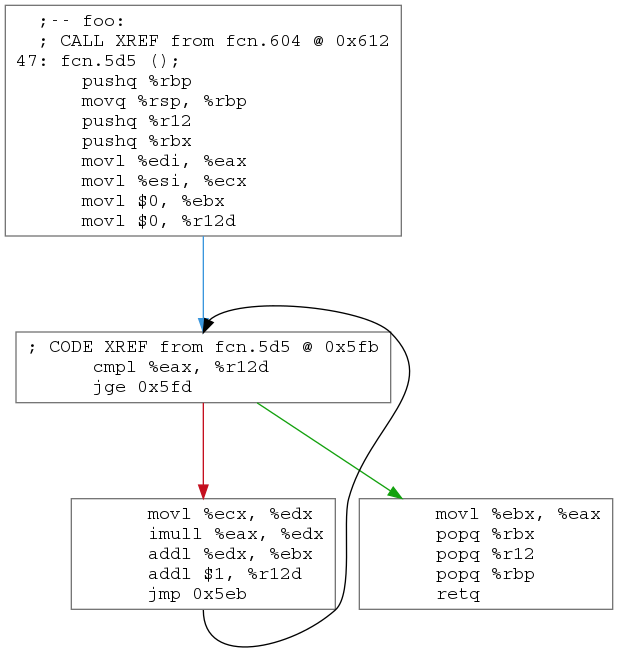
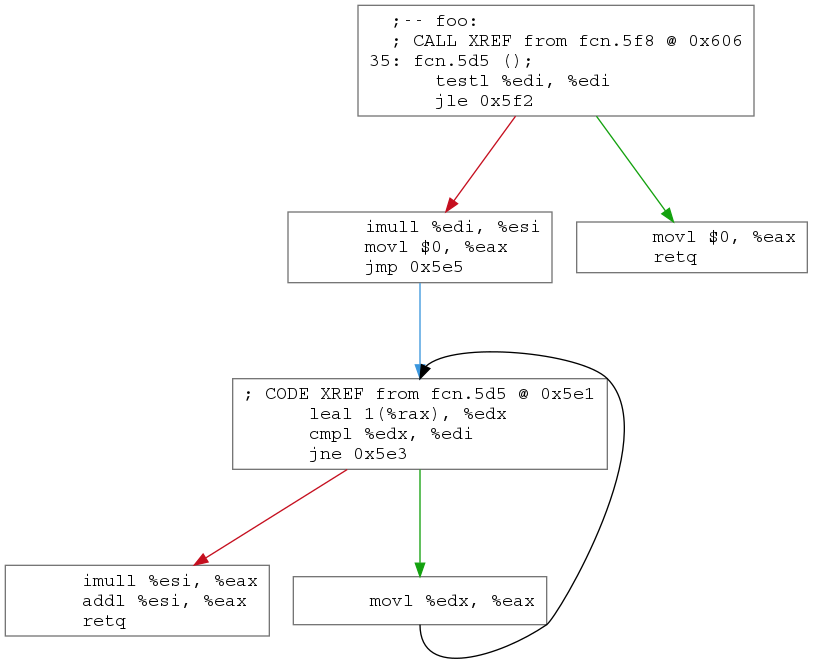

In [2]:
unopt = fiddle("LICM.cpp", function="foo", run=False, trim_addresses=True, code="""

extern "C" int foo(register int a, register int b){
    register int c = 0;
    for(register int i = 0; i < a; i++) {
        c += b*a;
    }
    return c;
}

int main(){
    return foo(1, 0);
}
""")
opt = fiddle("LICM.cpp", function="foo", run=False, trim_addresses=True, opt="-O1")
display(unopt.source)
compare([unopt.asm, opt.asm], ["Unoptimized", "Optimized (-O1)"])
compare([unopt.cfg, opt.cfg], ["Unoptimized", "Optimized (-O1)"])

Quite a bit has changed, but the key thing to notice is that the unoptimized code has an `imull` in the loop body while the optimized code does not.  In the optimized code, the `imull` has been moved into a new basic block called a _loop header_.

## Strength reduction

In a _strength reduction_ the compiler converts a "stronger" (i.e., more general and/or slower) operation into a "weaker" (i.e. less general and/or faster) operation.  The most common example is converting multiplication and division by powers of two into left and right shifts.

For example:

In [20]:
#KEY answer_cell
unopt = fiddle("SR.cpp", function="foo", run=False, trim_addresses=True, code="""
extern "C" int foo(register unsigned int a, register unsigned int b){
    return a *8;
}

int main(){
    return foo(1, 0);
}
""")
opt = fiddle("SR.cpp", function="foo", run=False, trim_addresses=True, opt="-O1")
display(unopt.source)
compare([unopt.asm, opt.asm], ["Unoptimized", "Optimized (-O1)"])

Compiling your code...
rm -f build/SR.s SR.exe build/SR.o

make build/SR.s SR.exe C_OPTS='' 
mkdir -p build/
cp SR.cpp build/SR.cpp 
g++-8 -S -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/SR.cpp -o build/SR.s
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/SR.cpp -o build/SR.o
g++-8 build/SR.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -lboost_program_options -lm -lquadmath -ldl    -o SR.exe

Compiling your code...
rm -f build/SR.s SR.exe build/S

// SR.cpp:2-4 (3 lines)
extern "C" int foo(register unsigned int a, register unsigned int b){
    return a *8;
}

We don't even need to look at the optimized code to find strength reduction.  Strength reduction is such a common optimization that the compiler does it even when we tell it not to optimized.  Note that there is no `mull` instruction, but there is a shift arithmetic left long (`sall`) instruction with a constant `$3` that multiplies `%eax` by 8.

The optimized code does one better and folds the whole function in one `leal`.  The `n(,%r,k)` addressing mode multiplies register `%r` times `k` and adds it to `n`.  `k` must be power of two, which means that the processor can use a left shift to implement it.

<div class="question completeness">

<div class="question-text">

Modify the fiddle so that the `0` in the `leal`s first argument becomes a 4.
    
</div>

<div class="answer">
#KEY return 4 + a * 8;
</div>
</div>

Changing multiplies and divides to shifts is not the only kind of strength reduction that is possible.  In the fiddle below change the `a*8` to the expressions given in the question and see what the compiler dose:

In [21]:
#KEY answer_cell
unopt = fiddle("SR2.cpp", function="foo", run=False, trim_addresses=True, code="""
extern "C" int foo(register unsigned int a, register unsigned int b){
    return a *8;
}
int main(){
    return foo(1, 0);
}
""")
opt = fiddle("SR2.cpp", function="foo", run=False, trim_addresses=True, opt="-O1")
display(unopt.source)
compare([unopt.asm, opt.asm], ["Unoptimized", "Optimized (-O1)"])

Compiling your code...
rm -f build/SR2.s SR2.exe build/SR2.o

make build/SR2.s SR2.exe C_OPTS='' 
cat: short_name: No such file or directory
cat: short_name: No such file or directory
mkdir -p build/
cp SR2.cpp build/SR2.cpp 
g++-8 -S -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/SR2.cpp -o build/SR2.s
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/SR2.cpp -o build/SR2.o
g++-8 build/SR2.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -lboost_progra

// SR2.cpp:2-4 (3 lines)
extern "C" int foo(register unsigned int a, register unsigned int b){
    return a *8;
}

<div class="question completeness">

#### (Completeness) Try replacing `a*8` with each of the following.  Describe what the compiler does:

<div class="answer">

|        | What the compiler did | 
|--------|-----------------------|
| `a*3`   |  |  
| `a*5`|  |
| `a*11`|  |
| `a/b`| |
| `a/3`| |

</div>
</div>

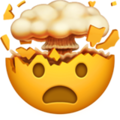

## Constant propagation

_Constant propagation_ allows the compiler to identify the value of constant expressions at compile time and use those constant values to simplify computations.

For example:

In [24]:
unopt = fiddle("CP.cpp", function="foo", run=False, trim_addresses=True, code="""

extern "C" int foo(register int a, register int b){
    register int c = 4;
    register int d = 4;
    return a + c + d;
}

int main(){
    return foo(1, 0);
}
""")
opt = fiddle("CP.cpp", function="foo", run=False, trim_addresses=True, opt="-O1 -fno-inline")
display(unopt.source)
compare([unopt.asm, opt.asm], ["Unoptimized", "Optimized (-O1)"])

Compiling your code...
rm -f build/CP.s CP.exe build/CP.o

make build/CP.s CP.exe C_OPTS='' 
mkdir -p build/
cp CP.cpp build/CP.cpp 
g++-8 -S -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/CP.cpp -o build/CP.s
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/CP.cpp -o build/CP.o
g++-8 build/CP.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -lboost_program_options -lm -lquadmath -ldl    -o CP.exe

Compiling your code...
rm -f build/CP.s CP.exe build/C

// CP.cpp:3-7 (5 lines)
extern "C" int foo(register int a, register int b){
    register int c = 4;
    register int d = 4;
    return a + c + d;
}

Again, the compiler is doing multiple things at once, but the constant propagation is visible:  In the unoptimized code, it moves `$4` into both `%r12d` and `%ebx` and then adds both those register to `%eax` on the next two lines.  In the optimized code it's folded both `4`s into the `8` in the `leal` instruction.  Here, `leal` is using the `n(%r)` addressing mode which adds a constant `n` to `%r`.  In this case, that enough to implement the entire function.

So what happened to variables `c` and `d`?  They are gone!

The compiler can make bigger things disappear:

In [25]:
unopt = fiddle("CP2.cpp", function="foo", run=False, trim_addresses=True, code="""

extern "C" int foo(register int a, register int b){
    register int i, s = 0;
    for(i = 0; i < 10; i++) {
        s+= i;
    }
    return s;
}

int main(){
    return foo(1, 0);
}
""")
opt = fiddle("CP2.cpp", function="foo", run=False, trim_addresses=True, opt="-O1 -fno-inline")
display(unopt.source)
compare([unopt.asm, opt.asm], ["Unoptimized", "Optimized (-O1)"])

Compiling your code...
rm -f build/CP2.s CP2.exe build/CP2.o

make build/CP2.s CP2.exe C_OPTS='' 
mkdir -p build/
cp CP2.cpp build/CP2.cpp 
g++-8 -S -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/CP2.cpp -o build/CP2.s
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/CP2.cpp -o build/CP2.o
g++-8 build/CP2.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -lboost_program_options -lm -lquadmath -ldl    -o CP2.exe

Compiling your code...
rm -f build/CP2.s 

// CP2.cpp:3-9 (7 lines)
extern "C" int foo(register int a, register int b){
    register int i, s = 0;
    for(i = 0; i < 10; i++) {
        s+= i;
    }
    return s;
}

Bye, bye loop!

![Bye bye](https://media3.giphy.com/media/SABGACIrfegQ4O1Aey/200w.webp?cid=ecf05e47aa8u3emxknrkw6fv3rpkesce1x1nog5t1hjpoang&rid=200w.webp&ct=g)

## Loop Unrolling

The example above also demonstrates _loop unrolling_.  In loop unrolling, the compiler "unrolls" a loop so that the loop body contains the computation for multiple iterations of the loop.  For instance:

In [27]:
unopt = fiddle("unroll1.cpp", function="foo", run=False, trim_addresses=True, opt="-O0", code="""

extern "C" int foo(register unsigned int a, register unsigned int b){
    register unsigned int i, s = 0;
    for(i = 0; i < b*8; i++) {
        s+= i;
    }
    return s;
}

int main(int argc, char *argv[]){
    return foo(1, argc);
}
""")
opt = fiddle("unroll1.cpp", function="foo", run=False, trim_addresses=True, opt="-O1 -funroll-all-loops")
display(unopt.source)
compare([unopt.cfg, opt.cfg], ["Optimized but not unrolled", "Unrolled"])

Compiling your code...
rm -f build/unroll1.s unroll1.exe build/unroll1.o

make build/unroll1.s unroll1.exe C_OPTS='-O0' 
mkdir -p build/
cp unroll1.cpp build/unroll1.cpp 
g++-8 -S -c -Wall -Werror -g  -O0    -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/unroll1.cpp -o build/unroll1.s
gcc-8 -c -Wall -Werror -g  -O0    -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/unroll1.cpp -o build/unroll1.o
g++-8 build/unroll1.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -lboost_program_options -lm -lquadmath -ldl

TypeError: 'NoneType' object is not subscriptable

<div class="question correctness points-3">

<div class="question-text">
    
If `b` is 4 and CPI remains constant, how much speedup would expect from unrolling the loop (Show your work)?</div>
    
<div class="answer">
    
#KEY without opt: before = 5; after = 1; loop = 4*8*4 = 128; total = 134
    
#KEY with opt: before + after = 6;  loop = 4 * 18 = 78

#KEY speedup = 134/78 = 1.7x
</div>
    

</div>

The example above is simplified since the loop bound is `8*b`.  From experience, I know that gcc likes to unroll loops 8 times, so this makes the number of iterations work out nicely.  Replace the loop bound with `b` and running it again.

<div class="question completeness">

<div class="question-text">

Why did the compiler add the additional basic blocks that appeared in the CFG?  For an (optional) challenge, explain how they work.</div>
    
    
<div class="answer">
#KEY they run the loop forward until the number of remaining loop iterations is divisible by 8.
</div>
</div>

<div class="question optional">

<div class="question-text">

What happens if you replace `b*8` with `8`?
    </div>    
    
<div class="answer">
</div>
</div>

## Combining Single-function Optimizations

Each of these optimizations is interesting in isolation, but they are more powerful together.

Compiling your code...
rm -f build/CP.s CP.exe build/CP.o

make build/CP.s CP.exe C_OPTS='' 
mkdir -p build/
cp CP.cpp build/CP.cpp 
g++-8 -S -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/CP.cpp -o build/CP.s
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/CP.cpp -o build/CP.o
g++-8 build/CP.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -lboost_program_options -lm -lquadmath -ldl    -o CP.exe

Compiling your code...
rm -f build/CP.s CP.exe build/C

// CP.cpp:4-14 (11 lines)
extern "C" uint32_t div_loop(uint64_t * array,
        unsigned long int size) {
#define X 3
#define Y 8
#define DIV(a,b) (a / b)

    for(uint32_t i = 0; i < DIV(size, 3); i++) {
        array[DIV(i, 2) +  DIV(Y, X)] = DIV(size, 3);
    }
    return array[0];
}


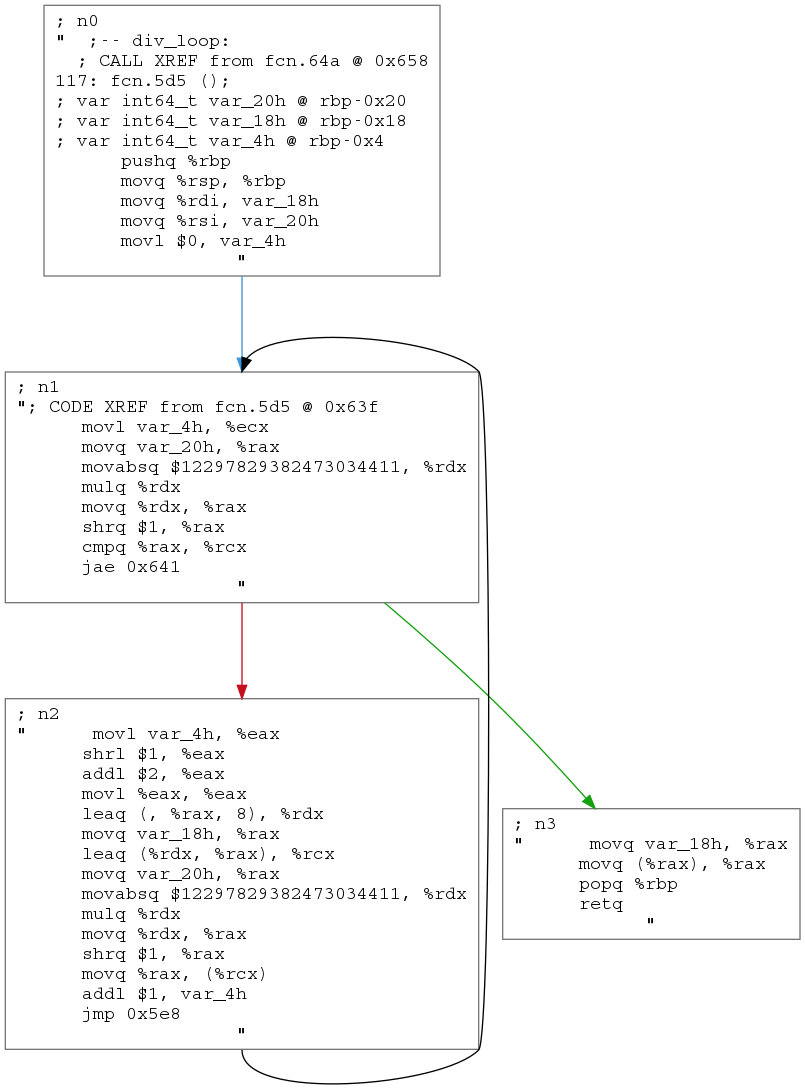
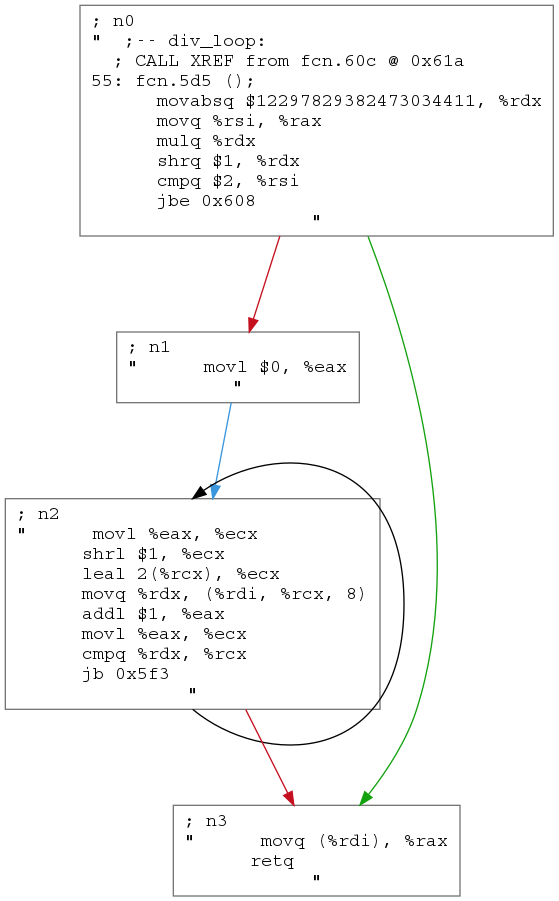

In [43]:
unopt = fiddle("CP.cpp", function="div_loop", run=False, number_nodes=True, trim_addresses=True, code="""
#include<cstdint>
#include<cstdlib>
extern "C" uint32_t div_loop(uint64_t * array,
        unsigned long int size) {
#define X 3
#define Y 8
#define DIV(a,b) (a / b)

    for(uint32_t i = 0; i < DIV(size, 3); i++) {
        array[DIV(i, 2) +  DIV(Y, X)] = DIV(size, 3);
    }
    return array[0];
}

int main(){

    return div_loop(NULL, 12);
}
""")
opt = fiddle("CP.cpp", function="div_loop", run=False, number_nodes=True, trim_addresses=True, opt="-O1 -fno-inline")
display(unopt.source)
compare([unopt.cfg, opt.cfg], ["Unoptimized", "Optimized (-O1)"])

So, how many divides (i.e., instructions with `div` in their names) are there?  Something strange is going on.  How is the compiler dividing (hint:  it's the weirdest looking thing in this code) Even if you don't know how _exactly_ it's dividing, can you tell _how many times_ its dividing?

<div class="question completeness">

<div class="question-text">

For each `DIV()` in the code above, list the optimizations that the compiler applied to the code and the combined effect they had.  (hint: the optimizations we've discussed are sufficient)
    
</div>
    
<div class="answer">
    
|              | optimizations | effect |
|--------------|---------------|--------|
|DIV(size,3)  |  #KEY LICM, strength reduction | converted to multiply; moved out of loop | 
|  DIV(8/3)   | #KEY Constant prop. | Convert to constant; removed. | 
|  DIV(i,2)   | #KEY strength reduction. | coverted to shift | 
    
</div>
</div>

<div class="solution">
    
`DIV(size,3)`:  If you go looking for this divide in the unoptimized code, you won't find it:  The compiler uses strength reduction to convert division by a constant into multiplication by the inverse of that constant.  Or, to think about it another way, `size/3` becomes `size * 1/3`, is just algebra.  
    
The compiler does dutifully execute it twice:  The `1/3` is the `movabsq` instruction in unoptimized block `n1` and `n2` and that huge constant is `1/3`.
    
In the optimized code, the compiler recognizes that `DIV(size,3)` is loop-invariant and a common sub-expression, so all the instances of it gets moved into block `n0`, where it executes just once, rather than twice in each iteration.
    
`DIV(8/3)`:  This expression is a constant (`8/3 = 2` in integer math), so the compiler computes the value and stores it as the constant in the first `addl` in block `n2` of the unoptimized code.  Is the optimized code, it's the `2` in `2(%rcx)` in block `n2`.
    
`DIV(i/2)`:  Here, again, strength reduction happens even without optimizations turned on: This divide becomes `shrl` in unoptimized block `n2`. It's the same thing in the optimized version.

So, in total, the optimizer removed or optimized away everything by a single shift in the loop body.  You can also see that it removed a bunch of other instructions too.  For fun, you could figure out why the rest of them are not necessary.  
    
</div>

## Function Inlining

So far, all the optimizations have only affected a single function and none of them will have any impact on the call graph of our program.  This means they cannot hope to fix those monstrous call graphs that we got from invoking relatively simple STL functions and types.  Function _inlining_ will change all that.

### Function Call Overhead 

Before we get to inlining, let's talk a little about functions.  When you a write a function, the code you write turns into the "body" of the function.  However, the processor has to do some work to _make_ the function call and each function includes some overhead.  For example, consider this code:

In [29]:
fiddle("prologue.cpp", function="", run=False, opt="-Og", code="""

long int sum(long int a, long int b) {
    return a + b;
}

int main(){
    return sum(1,2);
}
""").asm


Compiling your code...
rm -f build/prologue.s prologue.exe build/prologue.o

make build/prologue.s prologue.exe C_OPTS='-Og' 
mkdir -p build/
cp prologue.cpp build/prologue.cpp 
g++-8 -S -c -Wall -Werror -g  -Og    -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/prologue.cpp -o build/prologue.s
gcc-8 -c -Wall -Werror -g  -Og    -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/prologue.cpp -o build/prologue.o
g++-8 build/prologue.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -lboost_program_options -lm -lq

; build/prologue.s:1-31 (31 lines)
	.file	"prologue.cpp"
	.text
	.globl	sum(long, long)
	.type	sum(long, long), @function
sum(long, long):
.LFB0:
	.cfi_startproc
	leaq	(%rdi,%rsi), %rax
	ret
	.cfi_endproc
.LFE0:
	.size	sum(long, long), .-sum(long, long)
	.globl	main
	.type	main, @function
main:
.LFB1:
	.cfi_startproc
	subq	$8, %rsp
	.cfi_def_cfa_offset 16
	movl	$2, %esi
	movl	$1, %edi
	call	sum(long, long)@PLT
	addq	$8, %rsp
	.cfi_def_cfa_offset 8
	ret
	.cfi_endproc
.LFE1:
	.size	main, .-main
	.ident	"GCC: (Ubuntu 8.4.0-1ubuntu1~18.04) 8.4.0"
	.section	.note.GNU-stack,"",@progbits

<div class="sidebar">
    <div class="title">The Application Binary Interface (ABI)</div>    

There are several standardized protocols for how arguments are passed to functions and even how names are mangled.  These protocols are called "application binary interfaces" or ABIs.  It's important that the caller (the function that calls) and the callee (the function that is called) agree on the ABI.   The ABI dictates which arguments go in which register and in what order, the number of bits in an `int` vs a `long int`, how things like pass-by-value vs. pass-by-references are implemented, and how C++ virtual function tables (which implement virtual functions) are laid out. Generally speaking, if two object files (i.e., `.o` files) were compiled with the same ABI, functions in one object file can call functions in another.  

For the most part, you can think of there being one ABI per operating system, but that's not completely accurate.  Linux has (at least two) one for the kernel and one for user programs.  Microsoft has one.  Intel has defined a standard as well.  The [wikipedia page](https://en.wikipedia.org/wiki/Application_binary_interface) has a little more detail.
    
If you're curious, use the fiddle to see how the compiler passes, `struct`s, pointers to `struct`, and C++ references to `struct`s.  What's surprising about how it implements those three different language constructs?
    
</div>


The body of `sum` is very simple:  It should just be a single add instruction, but instead it has to return as well.   The _call site_ in `main` is takes 3 instructions (the `ret` is part of the overhead for calling `main`, not `sum`).

In this case, the _function call overhead_ is four instructions: 1 x `ret`, 2 x `movl`, and 1 x `call`.

<div class="question optional">

<div class="question-text">

What happens to function call overhead if you add more arguments (something interesting happens past 8)?  What if pass a struct?   How does the complexity of _the caller_ affect function call overhead?
    
</div>
    
<div class="answer">
    
    
</div>
</div>



Recall the earlier example with `std::sort` and how many function calls were involved.  Each of them incurred this kind of overhead.  What a waste!

### Removing Function Call Overheads

One way to remove the function call overhead is to copy the body of the function (i.e., the useful bar) to the caller.  Then, we don't need to pass arguments, make the `call`, or do the `ret`.
The compiler can do this automatically by _inlining_ the function.

For instance, the compiler can inline `foo` into `loop`:

Compiling your code...
rm -f build/inline1.s inline1.exe build/inline1.o

make build/inline1.s inline1.exe C_OPTS='-Og' 
mkdir -p build/
cp inline1.cpp build/inline1.cpp 
g++-8 -S -c -Wall -Werror -g  -Og    -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/inline1.cpp -o build/inline1.s
gcc-8 -c -Wall -Werror -g  -Og    -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/inline1.cpp -o build/inline1.o
g++-8 build/inline1.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -lboost_program_options -lm -lquadmath -ldl


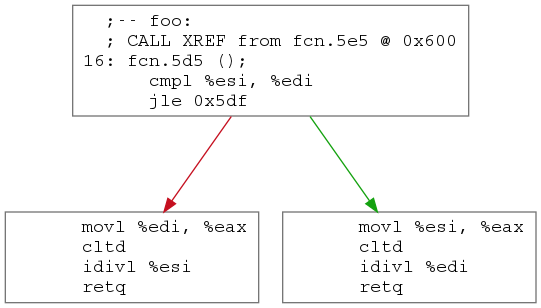


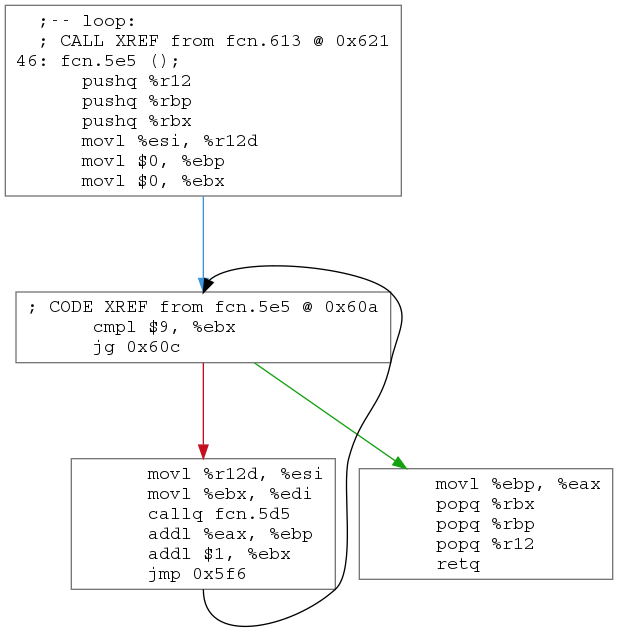


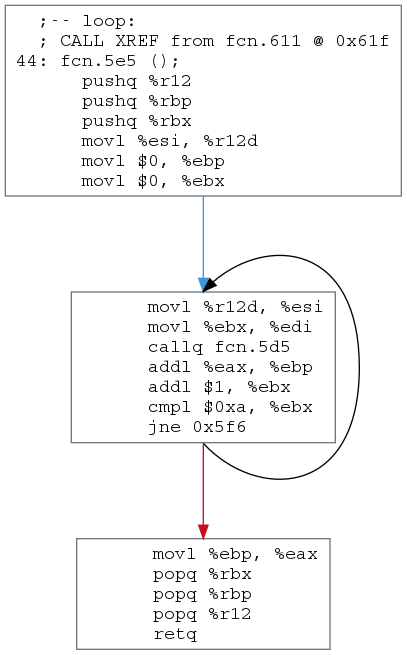

In [57]:
loop_unopt = fiddle("inline1.cpp", function="loop", run=False, remove_assembly=False, opt="-Og", code="""

extern "C" int foo(register int a, register int b) { 
    if (a > b) {
        return a/b;
    } else {
        return b/a;
    }
}

extern "C" int loop(register int a, register int b) {
    register int i;
    register int s = 0;
    for(i = 0; i < 10; i++) {
        s += foo(i, b);
    }
    return s;
}

int main(){
    return loop(10, 5);
}
""")
loop_opt = fiddle("inline1.cpp", function="loop", run=False, remove_assembly=False, opt="-O1 -finline-functions -fkeep-inline-functions")
foo_unopt = fiddle("inline1.cpp", function="foo", run=False, remove_assembly=False, opt="-Og ")
#foo_opt = fiddle("inline1.cpp", function="foo", run=False, remove_assembly=True, opt="-O1 -finline-functions -fkeep-inline-functions")

compare([foo_unopt.source, foo_unopt.cfg], ["foo()", "No inlining"])
compare([loop_unopt.source, loop_unopt.cfg], ["loop()", "No inlining"])
compare([loop_opt.cfg], ["loop() with inlining"])


When the compiler is finished with `loop()` it contains all the code that was in `foo()`.  It also no longer contains a function call at all.

<div class="question completeness">

<div class="question-text">

Based on the change in instruction count (IC), how much speedup does inlining provide in this case? 
    
</div>
    
<div class="answer">
    
</div>
</div>

<div class="solution">
    
Without inlining, each trip through `for` loop takes 14 instructions (8 in `loop()` and 6 in `foo()`).  With inlining, it's either 9 or 10 (depending on which way the branch goes).  Let's call it 9.5.  So the speedup (ignoring the first and last basic block) approximately 14/9.5 = 1.5x.
</div>

But this is just the beginning of inlining's power, because it also vastly increases the opportunities to apply other optimizations.  Consider `foo()` in the example above.  Without inlining, the compiler can only apply optimizations that will work for _all_ values of `a` and `b`.  However, once `foo()` in inlined, the compiler can optimize _that copy_ of `foo()` for the values of `a` and `b` at that call site.  Then it is free to apply all the other optimizations we've discussed already.

For instance:

Compiling your code...
rm -f build/inline2.s inline2.exe build/inline2.o

make build/inline2.s inline2.exe C_OPTS='-Og' 
mkdir -p build/
cp inline2.cpp build/inline2.cpp 
g++-8 -S -c -Wall -Werror -g  -Og    -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/inline2.cpp -o build/inline2.s
gcc-8 -c -Wall -Werror -g  -Og    -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/inline2.cpp -o build/inline2.o
g++-8 build/inline2.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -lboost_program_options -lm -lquadmath -ldl


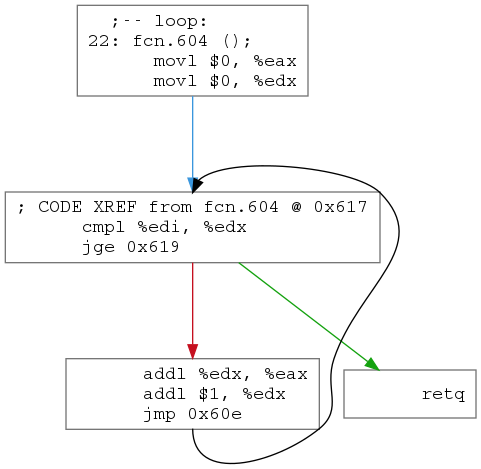


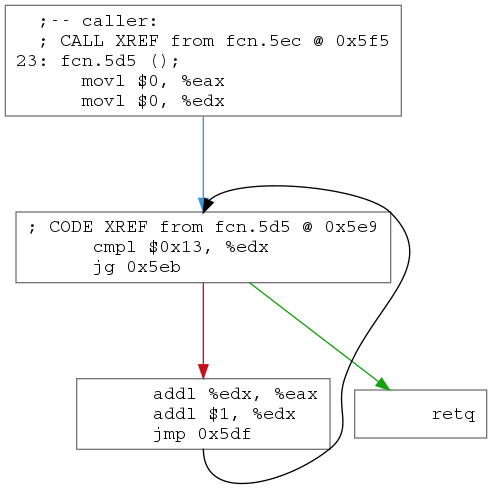


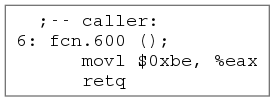

In [35]:
caller_unopt = fiddle("inline2.cpp", function="caller", run=False, remove_assembly=False, opt="-Og", code="""

extern "C" inline int loop(register int a) { 
    register int i;
    register int sum = 0;
    for(i = 0; i < a; i++) {
        sum += i;
    }
    return sum;
}

extern "C" int caller(register int a) {
    return loop(20);
}

int main(){
    caller(1);
}
""")
caller_opt = fiddle("inline2.cpp", function="caller", run=False, remove_assembly=False, opt="-O3")
loop_unopt = fiddle("inline2.cpp", function="loop", run=False, remove_assembly=False, opt="-Og -fkeep-inline-functions")

compare([loop_unopt.source, loop_unopt.cfg], ["loop()", "No inlining"])
compare([caller_unopt.source, caller_unopt.cfg], ["caller()", "No inlining"])
compare([caller_opt.cfg], ["caller() with inlining"])


Bye bye, function call!  Bye Bye, loop!

![bye bye](https://media3.giphy.com/media/tuvMgAPzxaQBq/200.webp?cid=ecf05e47jb4f5ojpiqlpr9o2b5wdn980swe4q4pcbwxmbxcu&rid=200.webp&ct=g)

<div class='question completeness'>

#### Which optimizations did the compiler apply to come up with inlined, optimized version of `caller()`?  For each optimization explain what it accomplished.
    
<div class='answer'>

#KEY Inlining -- merged in `foo()`.  
#KEY constant prop -- constant loop bound.
#KEY Loop unrolling -- Expand the loop.
#KEY constant prop -- evaluate unrolled loop.
</div>
</div>

# C++ Revisited

We now have all the tools we need to see how a compiler can handle the messiness of C++ and its standard library.  Here's the sort example from earlier:

Compiling your code...
rm -f build/sort_revisited.s sort_revisited.exe build/sort_revisited.o

make build/sort_revisited.s sort_revisited.exe C_OPTS='-O0' GPROF=yes
mkdir -p build/
cp sort_revisited.cpp build/sort_revisited.cpp 
g++-8 -S -c -Wall -Werror -g  -O0 -pg   -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/sort_revisited.cpp -o build/sort_revisited.s
gcc-8 -c -Wall -Werror -g  -O0 -pg   -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/sort_revisited.cpp -o build/sort_revisited.o
g++-8 build/sort_revisited.o   -pg -pthread   -L/usr/local/l


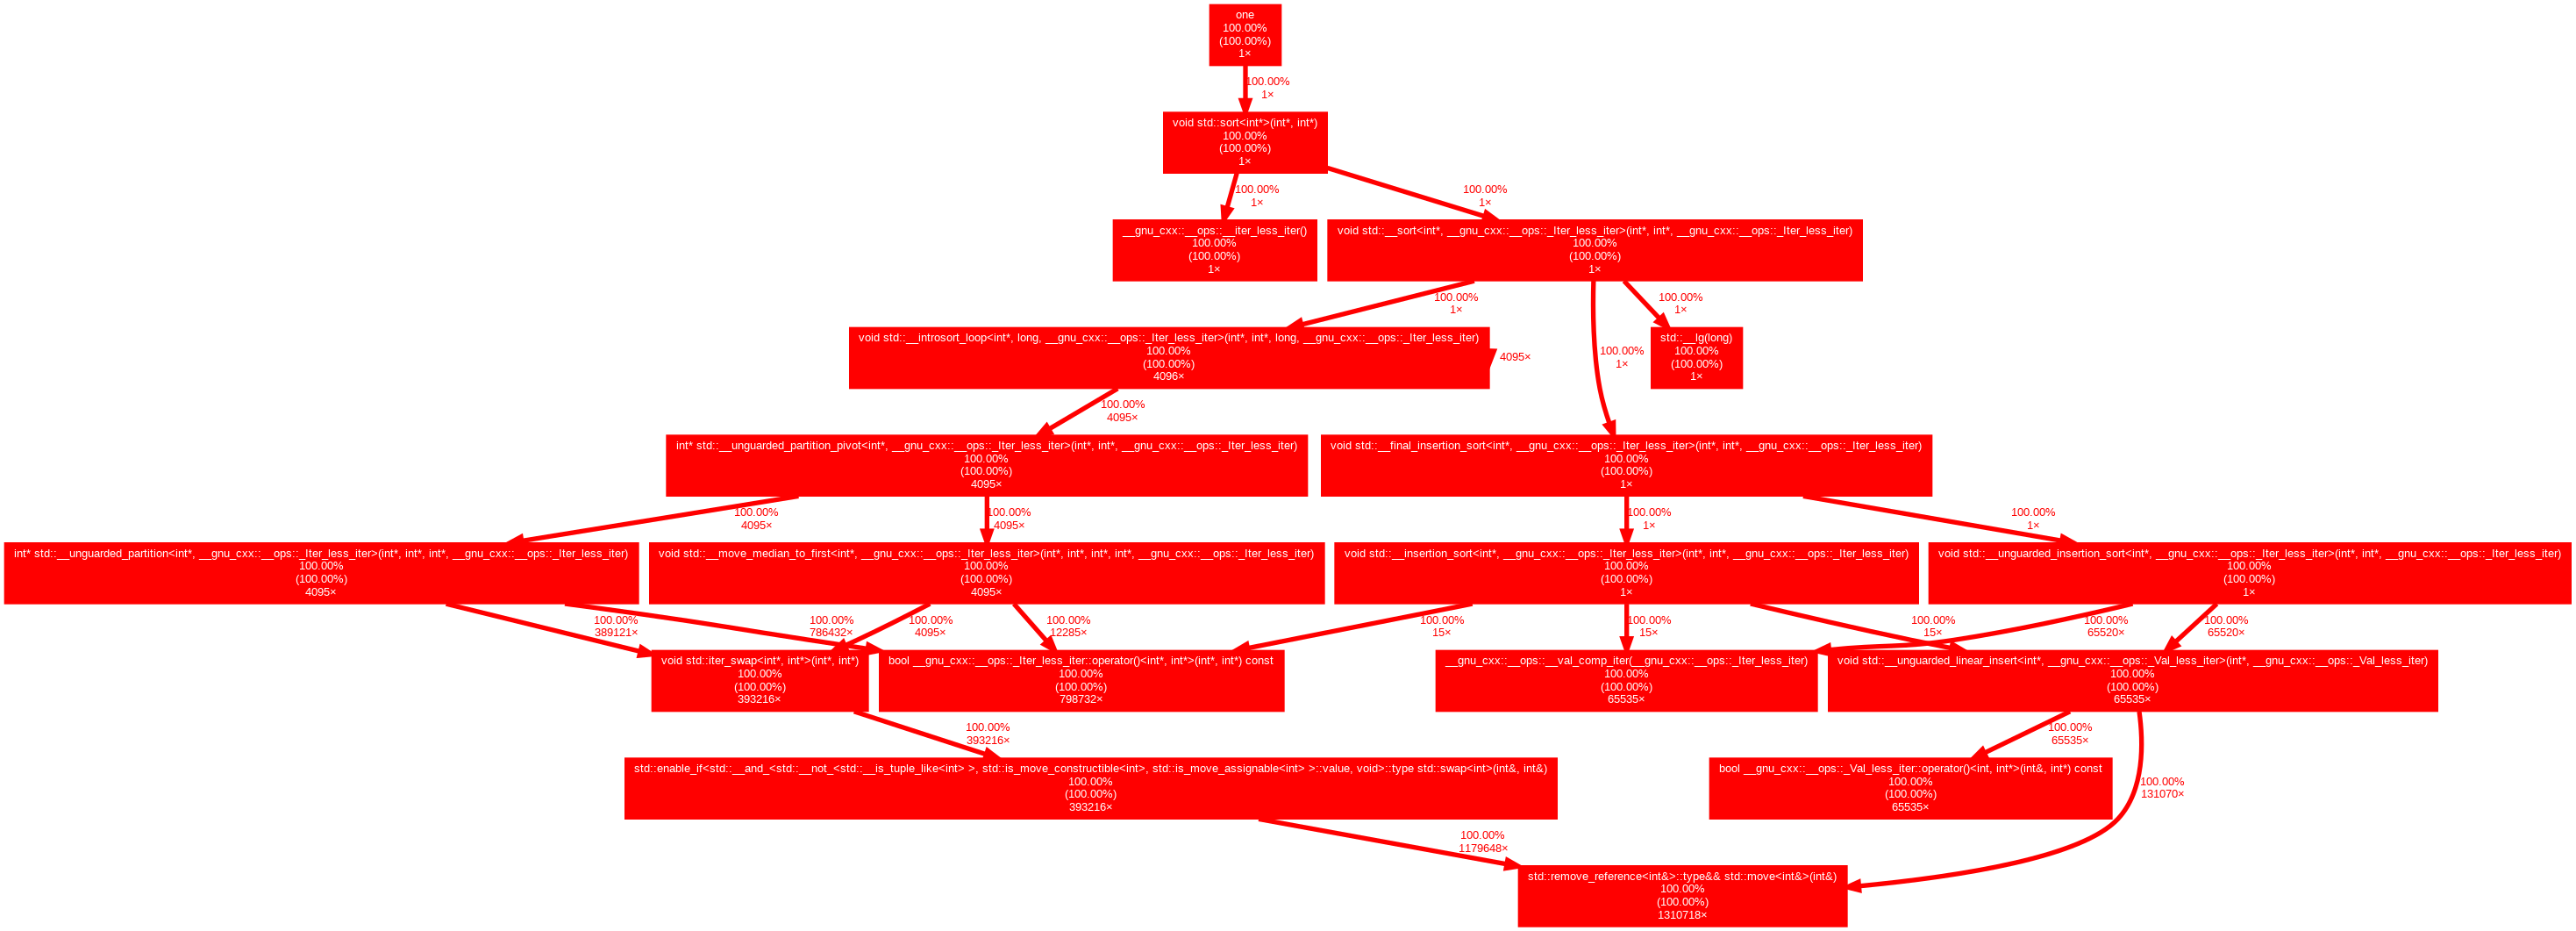
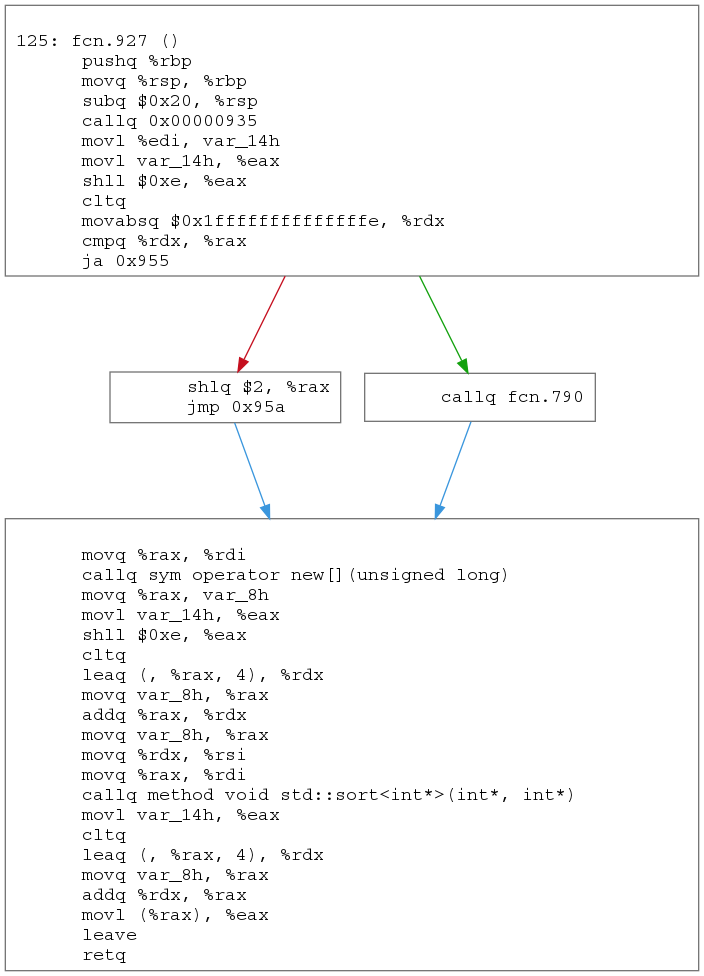


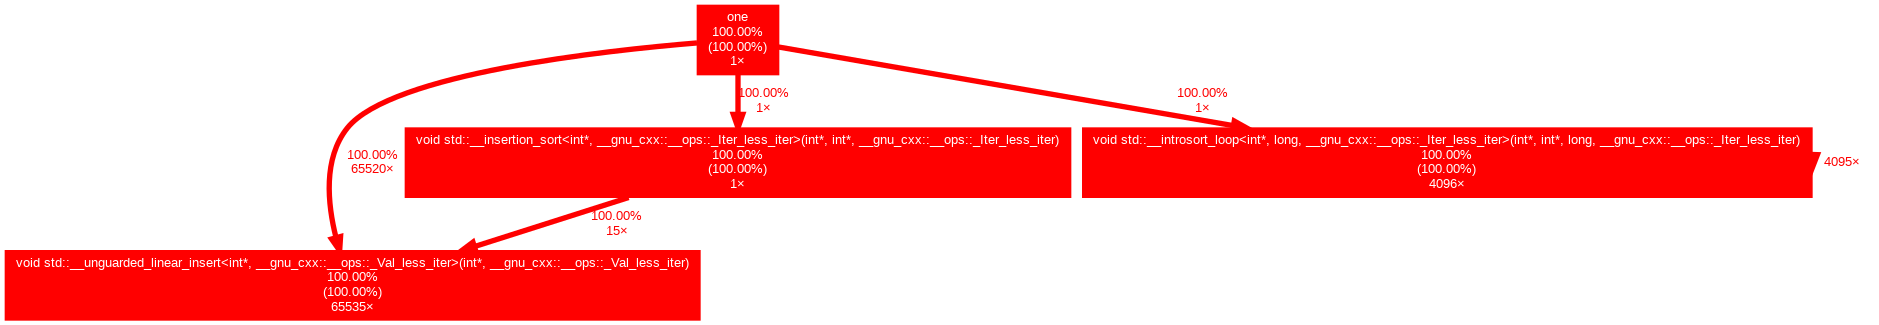
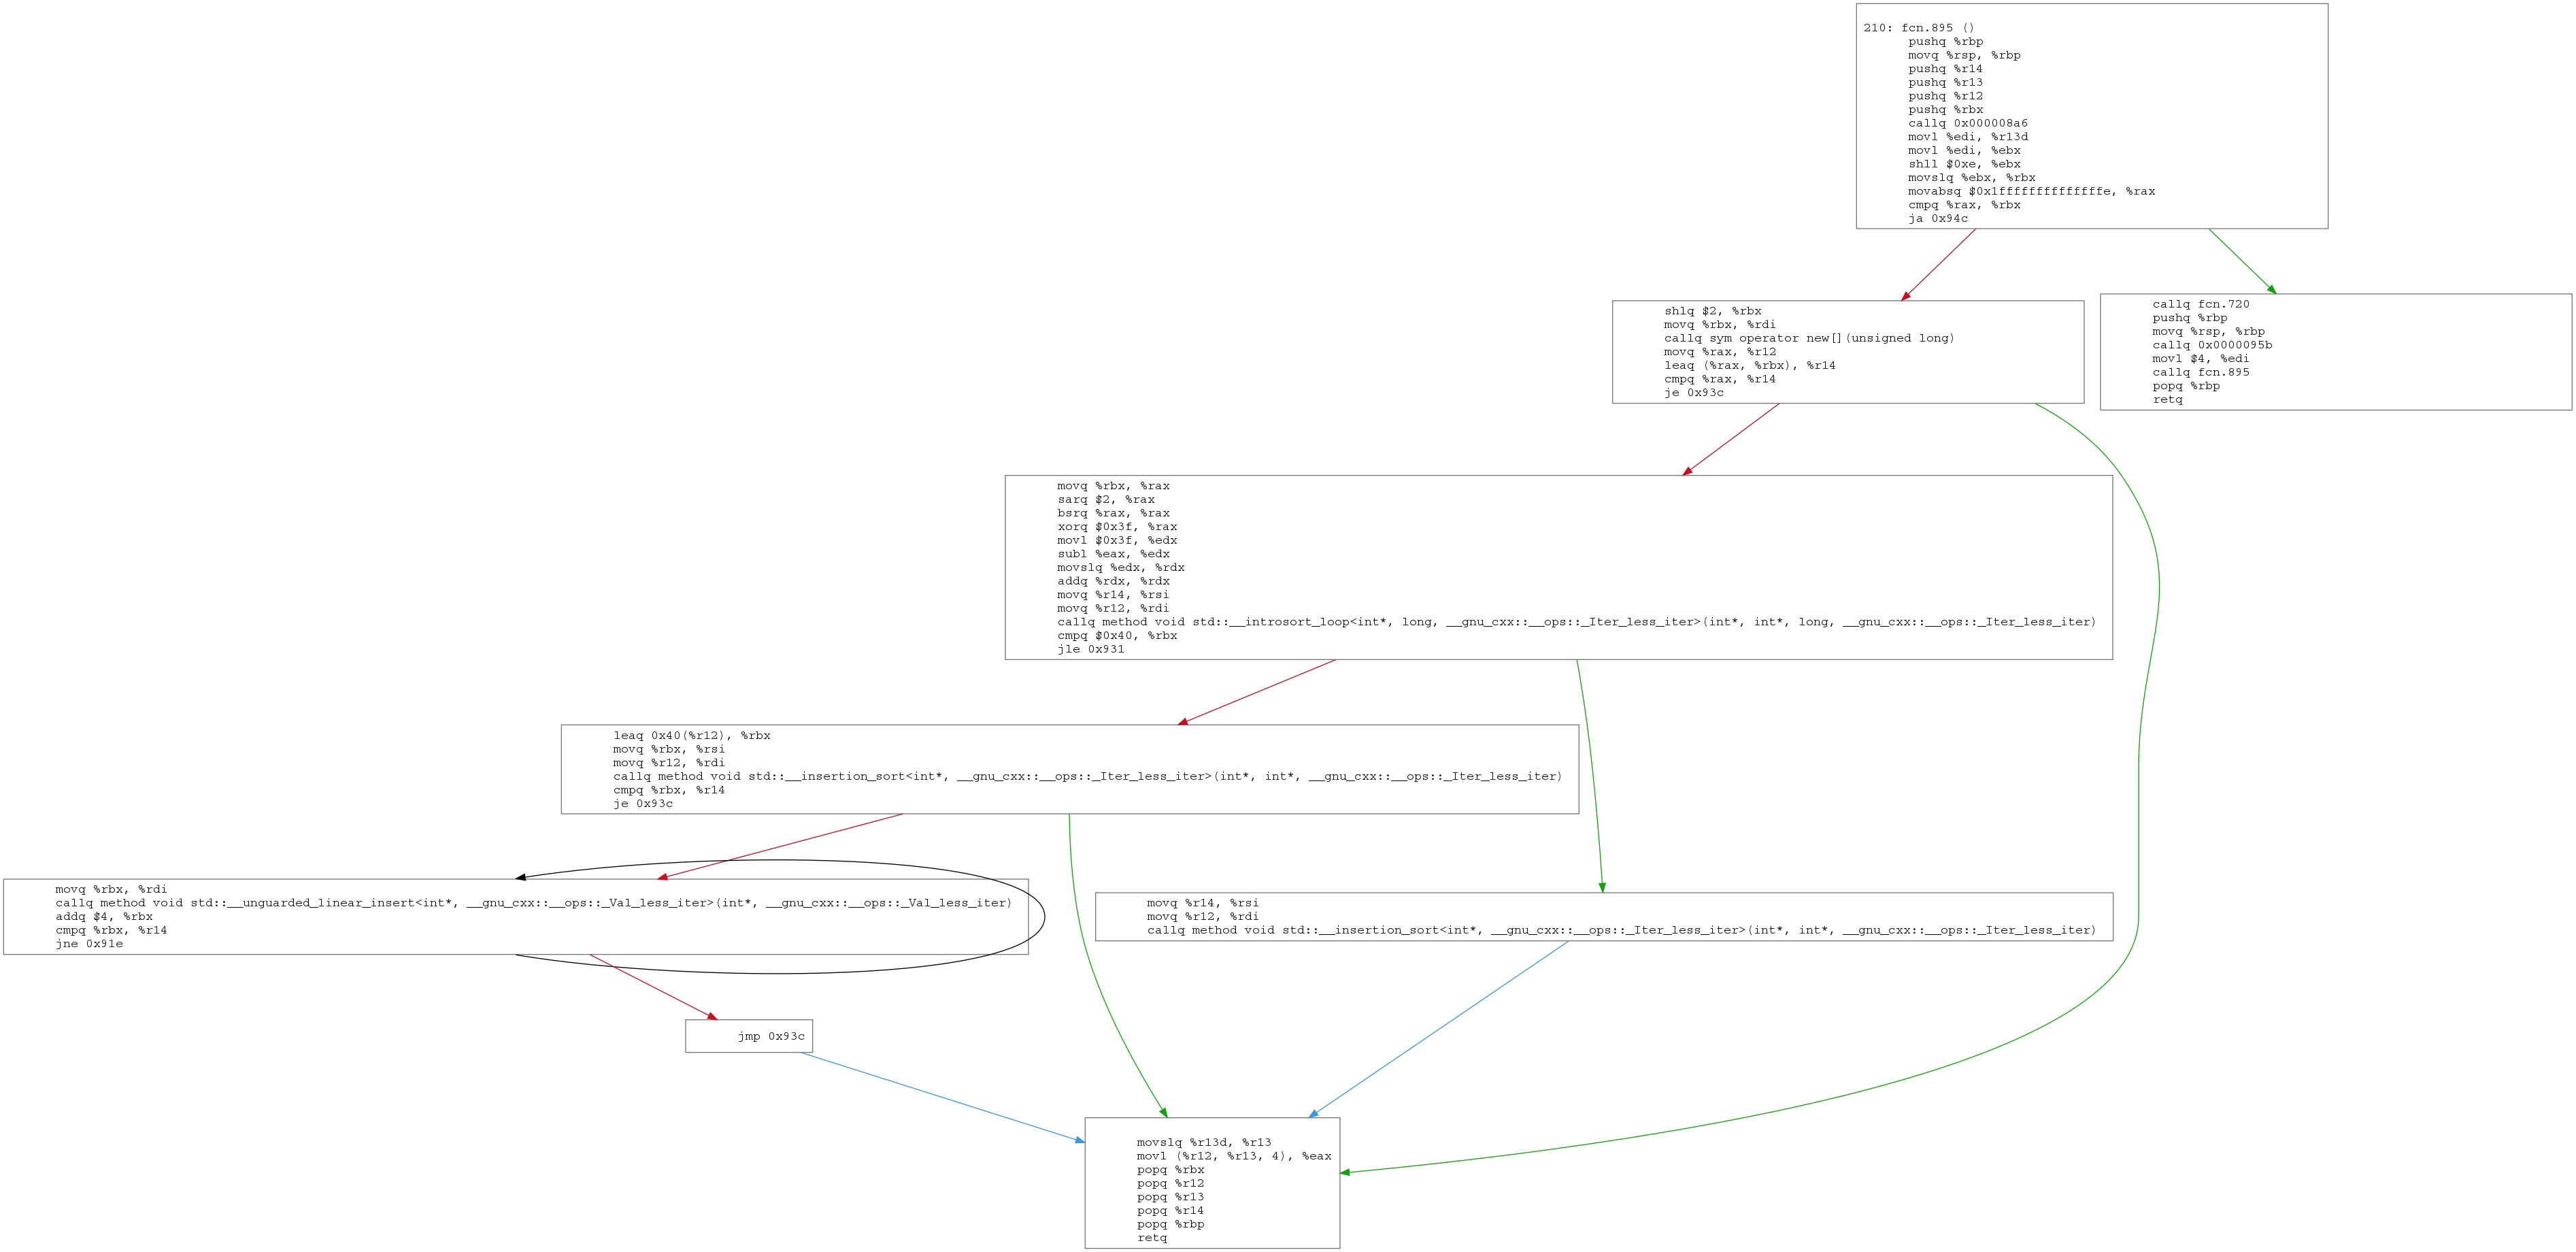

In [36]:
unopt = fiddle("sort_revisited.cpp", gprof=True, function="one", opt="-O0", code="""
#include<algorithm>
extern "C" int one(int a);

int main(int argc, char * argv[]) {
    return one(4);
}
#define ARRAY_SIZE (a*16*1024)
extern "C"  int one(int a) {
    int * array = new int[ARRAY_SIZE];
    std::sort(array, &array[ARRAY_SIZE]);
    return array[a];
}

""", remove_assembly=False,  trim_addresses=True, trim_comments=True)
opt = fiddle("sort_revisited.cpp", gprof=True, function="one", opt="-O1 -finline-functions", 
                 remove_assembly=False,  
                 trim_addresses=True, 
                 trim_comments=True)
compare([unopt.call_graph, unopt.cfg],["Unoptimized call graphs", "Unoptimized CFG for one()"])
compare([opt.call_graph, opt.cfg],["Optimized call graph", "Optimized CFG for one()"])

What a difference some optimization can make!  A few things to note:

1. The call to `std::sort()` is gone.  It's been inlined into `one()`, which now calls several other functions (e.g., `std::__introsort_loop()` and `std::__unguarded_linear_insert()`.
2.  The CFG for `one()` is more complex because it contains parts of `std::sort`.
3.  The optimized call graph above is _much_ shallower, and there are vastly few function calls.  The call graph is probably missing some calls due to some limitations of `gprof` (there are a few other function calls in `one()`), but the situation is clearly much better.

There's a large impact on performance as well.  The cell below runs a very similar code to the fiddle above, and this cell takes a while...:

In [2]:
!make clean
!make sort.exe sort_O3.exe sort_Og.exe

rm -rf build/ .tmp
rm -rf *.gv *-gv.pdf *.pin-trace #*.csv 
rm -rf *.exe *.o *.i *.s *.out *.d *.gcda *.gcno *.gprof *.gcov *.csv.raw core	
rm -rf 
mkdir -p build/
cp sort.cpp build/sort.cpp 
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/sort.cpp -o build/sort.o
mkdir -p build/
cp main.cpp build/main.cpp 
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/main.cpp -o build/main.o
g++-8 build/sort.o build/main.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -lboost

In [6]:
!cse142 job run --take "sort*.exe" --take '*.cfg' './sort.exe    --function stl_sort --reps 1 --stats sort_0.csv  --MHz 3500 --size 10000000  --stat-set PE.cfg --tag optimization=-O0'
!cse142 job run --take "sort*.exe" --take '*.cfg' './sort_O3.exe --function stl_sort --reps 1 --stats sort_3.csv  --MHz 3500 --size 10000000  --stat-set PE.cfg --tag optimization=-O3'
!cse142 job run --take "sort*.exe" --take '*.cfg' './sort_Og.exe --function stl_sort --reps 1 --stats sort_g.csv  --MHz 3500 --size 10000000  --stat-set PE.cfg --tag optimization=-Og'

You are submitting a job for lab "Lab 2: The Compiler" (compiler).
Creating job 4220abde-73d6-43bc-aa9e-a9cc0a6ca09e 0.00 0.00
Ready for submission. 4.56 4.56
Job 4220abde-73d6-43bc-aa9e-a9cc0a6ca09e is in state 'PUBLISHED'. 0.62 5.17 
Job 4220abde-73d6-43bc-aa9e-a9cc0a6ca09e is in state 'RUNNING'. 1.06 6.24....... 
Job 4220abde-73d6-43bc-aa9e-a9cc0a6ca09e is in state 'DONE_RUNNING'. 8.41 14.64.. 
Job 4220abde-73d6-43bc-aa9e-a9cc0a6ca09e succeeded. 3.16 17.81Writing results 1.00 18.81
Loading PAPI engine.
Tracking PAPI_TOT_INS
Tracking PAPI_TOT_CYC
Running stl_sort
Updated these files: ./sort_0.csv
./sort_0.csv.raw
Job Complete 0.50 19.31
You are submitting a job for lab "Lab 2: The Compiler" (compiler).
Creating job 412d97d3-eda9-4bb1-bebf-6eeea497f997 0.00 0.00
Ready for submission. 4.47 4.47
Job 412d97d3-eda9-4bb1-bebf-6eeea497f997 is in state 'PUBLISHED'. 0.41 4.89 
Job 412d97d3-eda9-4bb1-bebf-6eeea497f997 is in state 'RUNNING'. 1.05 5.94... 
Job 412d97d3-eda9-4bb1-bebf-6eeea497f99

In [7]:
!merge-csv sort_0.csv sort_3.csv > sort_opt.csv

optimization           IC       CPI            CT        ET
0          -O0  10703333446  0.903544  5.027373e-10  4.861937
1          -O3   1767229093  1.807250  5.032517e-10  1.607297

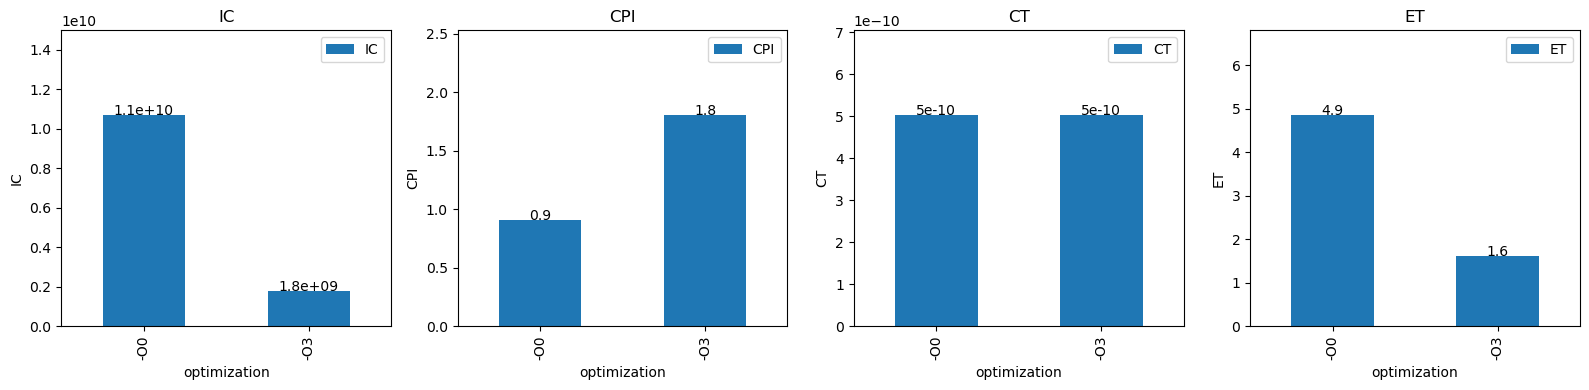

In [8]:
display(render_csv("sort_opt.csv", columns=["optimization", "IC", "CPI", "CT","ET"]))
plotPEBar("sort_opt.csv",
          what=[("optimization", "IC"),
                ("optimization", "CPI"),
                ("optimization", "CT"), 
                ("optimization", "ET")])

<div class="question correctness points-4">

<div class="question-text">
    
Based on the data above compute the "speedup" of `-O3` over `-O0` for `IC`, `CPI`, and `ET`.
</div>
    
<div class="answer">

|            | speedup | 
|------------|---------|
| `IC`       | #KEY should match their data.  5.9x     |
| `CPI`      | #KEY 2.11 |
| `CT` | #KEY 1 | 
| `ET`       | #KEY  2.82 |
    
</div>
    
</div>

In short, that is why you should compile your C++ code with optimizations turned on.

# Practical Rules For Using Compiler Optimizations

The single most important lesson to learn from this lab is that you should compile your code with optimizations turned on.  It is the easiest 2-10x boost in performance you can get.

Fortunately, it's pretty simple to do that well.  Somewhat overwhelmingly, Gcc provides around [300 flags](https://gcc.gnu.org/onlinedocs/gcc/Optimize-Options.html)  that control optimization and a bunch of tunable parameters as well, but in practice you don't need to worry about them.

There are just a handful that are typically useful.  Here's what the gcc docs have to say about them:

* `-O0`: Perform no optimizations.  You should never use this unless you're just playing around.
* `-O1`: "the compiler tries to reduce code size and execution time, without performing any optimizations that take a great deal of compilation time."
* `-O2`: "GCC performs nearly all supported optimizations that do not involve a space-speed tradeoff."  "Space" in this context means the number of static instructions generated.
* `-O3`: "Optimize yet more"
* `-Og`: "Optimize debugging experience. -Og should be the optimization level of choice for the standard edit-compile-debug cycle, offering a reasonable level of optimization while maintaining fast compilation and a good debugging experience."

Among these `-Og` is a relatively new flag that "optimize[s] the debugging experience".  What does that mean?  The optimizations we described above (especially function inlining, but others as well) can cause strange behavior when you debug.  For instance, consider the inlined version of `one()` in the previous section.  If you set a break point on `std::sort()`, your code would never stop because that function is never called.  Likewise, we've seen loops and variables disappear as well.  This can make debugging really difficult.  On the other hand, compiling with `-O0` will make the code much, much slower (just look at the graphs above).  So `-Og` strikes a balance:  It optimizes but avoids these problems.

Here's what that balance looks like:

In [ ]:
!merge-csv sort_0.csv sort_3.csv sort_g.csv > sort_opt_g.csv
display(render_csv("sort_opt_g.csv", columns=["optimization", "IC", "CPI", "CT","ET"]))
plotPEBar("sort_opt_g.csv",
          what=[("optimization", "IC"),
                ("optimization", "CPI"),
                ("optimization", "CT"), 
                ("optimization", "ET")])

Not a huge difference...  You might conclude that `-O3` is not worth, but I'd want to see data for a range of different, more realistic programs.

So, in practice you should:

* Use `-Og` when debugging and developing.
* Use `-O3` when deploying.

The other 298 options have their uses, but unless you are interested in squeezing out the very last drop of performance (and doing the experiments to check that the optimizations help), they are not worth the effort and are pretty hard to use productively.  It's usually a lot of trial and error.

That said, by the time you've finished this class, you'll have a pretty deep understanding of CPU performance and how to look "under the hood" at what the compiler is doing.  So, you'll be in a good position to read about those other options an design meaningful experiments that let you measure their impact.

# Limitations of the Compiler

Compiler optimizations can do a lot, but they are not magical.  In particular, they cannot save you from choosing the wrong algorithm or data stucture for a particular task.  Indeed, choosing the right algorithms and data structures can have even larger impacts on performance.

For instance, consider three well-known sorting algorithms `bubble_sort`, `insertion_sort`, `quick_sort`, and `stl:sort` (the implementation in the C++ `stl`.  It could be any $O(n \log(n))$ sorting algorithm):

In [ ]:
render_code("sort.cpp", show="bubble_sort")
render_code("sort.cpp", show="insertion_sort")
render_code("sort.cpp", show=("//START", "//END"))
render_code("sort.cpp", show="stl_sort")

Let's see how they perform sorting 64k elements:

In [10]:
!make sort_O3.exe
!cse142  job run --take "sort*.exe" --take '*.cfg' './sort_O3.exe --function bubble_sort insertion_sort quick_sort stl_sort --reps 1 --stats sorts.csv  --MHz 3500 --size 65536  --stat-set PE.cfg'

make: 'sort_O3.exe' is up to date.
You are submitting a job for lab "Lab 2: The Compiler" (compiler).
Creating job 2c03c1bb-9f6e-41d7-9077-1429d8f8fa1f 0.00 0.00
Ready for submission. 4.97 4.97
Job 2c03c1bb-9f6e-41d7-9077-1429d8f8fa1f is in state 'PUBLISHED'. 0.51 5.48. 
Job 2c03c1bb-9f6e-41d7-9077-1429d8f8fa1f is in state 'RUNNING'. 2.10 7.58.......... 
Job 2c03c1bb-9f6e-41d7-9077-1429d8f8fa1f is in state 'DONE_RUNNING'. 11.51 19.09.. 
Job 2c03c1bb-9f6e-41d7-9077-1429d8f8fa1f succeeded. 3.14 22.22Writing results 1.00 23.22
Loading PAPI engine.
Tracking PAPI_TOT_INS
Tracking PAPI_TOT_CYC
Running bubble_sort
Running insertion_sort
Running quick_sort
Running stl_sort
Updated these files: ./sorts.csv
./sorts.csv.raw
Job Complete 0.52 23.74


function           IC       CPI            CT        ET
0     bubble_sort  20395262003  1.428790  2.869217e-10  8.361055
1  insertion_sort   9653771274  0.230789  2.869032e-10  0.639215
2      quick_sort     16811067  0.901066  2.872253e-10  0.004351
3        stl_sort      8035766  1.689329  2.873614e-10  0.003901

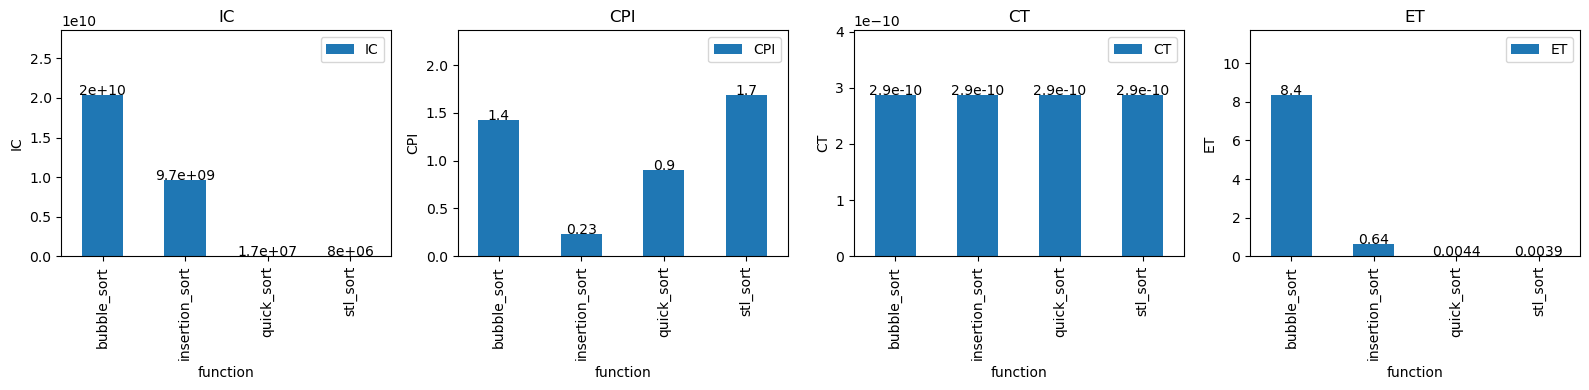

In [11]:
#KEY data_cell
plotPEBar("sorts.csv", [("function", "IC"), ("function", "CPI"), ("function", "CT"), ("function", "ET")])
display(render_csv("sorts.csv", ["function", "IC", "CPI", "CT", "ET"]))

<div class="question correctness points-1">

<div class="question-text">

What's the speedup of `quick_sort` over `bubble_sort`?
</div>
    
<div class="answer">
    #KEY math should be right.  I get 2090x.
    </div>
</div>

I'm actually not very happy with this measurement.  The runtime of `quick_sort` is too short for me to really think it's accurate -- I'd rather the runtime be in the 1-second range.  But getting `quick_sort` to take 1 second requires me to increase the array size by 100x.  Which would increase `bubble_sort`'s runtime by 10,000x, to about 30 hours.  In any case, lesson is clear: Don't use bubble sort!

But it's not just a question of choosing among different approaches to the same problem.  You need to make sure you are solving the problem you need to solve.  Consider the problem of finding the smallest value in an array.  Here's one implementation:

mkdir -p build/
cp find_min.cpp build/find_min.cpp 
gcc-8 -c -Wall -Werror -g  -O3    -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/find_min.cpp -o build/find_min.o
g++-8 build/find_min.o build/main.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -lboost_program_options -lm -lquadmath -ldl    -o find_min.exe
You are submitting a job for lab "Lab 2: The Compiler" (compiler).
Creating job 4d27cb2a-1340-40fb-9ee3-13dd6cfa5f5d 0.00 0.00
Ready for submission. 2.91 2.91
Job 4d27cb2a-1340-40fb-9ee3-13dd6cfa5f5d is in state 'PUBLISHED'. 0.62 3.53 
Job 4d27cb2a-1340-40fb-9ee3-13dd6cfa5f5d is in state 'RUNNING'. 1.04 4.57... 
Job 4d27cb2a-1340-40fb-9ee3-13dd6cfa5f5d is in state 'DONE_RUNNING'. 4.18 8.75... 
Job 4d27cb2a-1340-40fb-9ee3-13dd6cf

function          IC       CPI            CT        ET
0  find_min_reference  1168020338  2.085257  2.870001e-10  0.699024
1   find_min_solution  1168020482  2.077109  2.869988e-10  0.696290

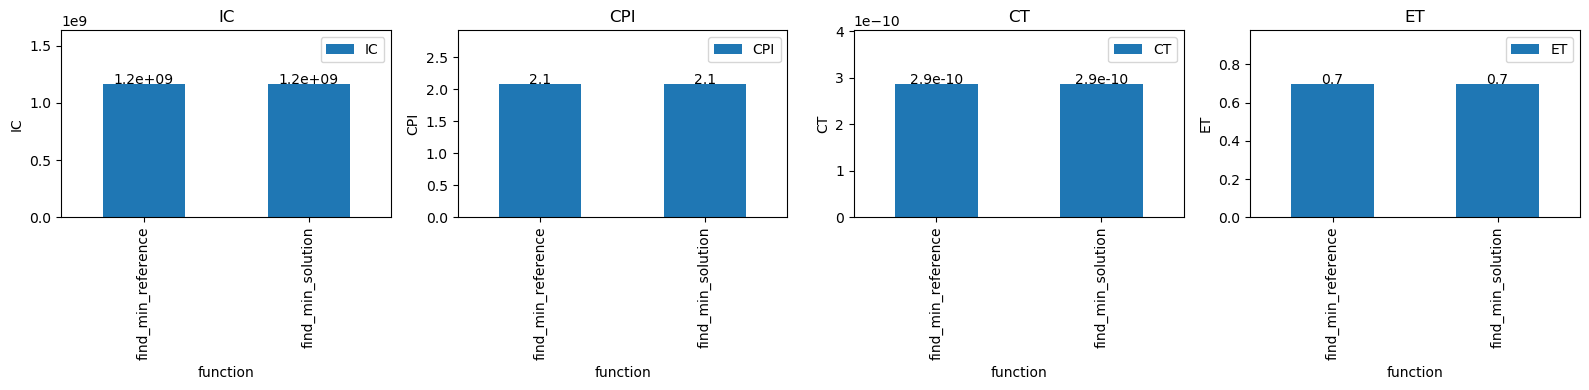

In [12]:
#KEY answer_cell
fiddle("find_min.cpp", compile=False, code=r"""
#include"function_map.hpp" // Don't remove this
#include<algorithm>
#include<cstdint>

// Reference implementation
uint64_t find_min_reference(uint64_t * a, uint64_t size) {
    std::sort(a, &a[size]);
    return a[0];
}

FUNCTION("find_min", find_min_reference); // Don't edit this.
/////////////////////////////////////////
// Don't edit anything above this line //
/////////////////////////////////////////

// Below you can implement as many different versions of the function as you'd like.
// To add another implementation, you need to do two things:
//
// 1. Create a function with the same signature (arguments and return type) and a different name.
// 2. Call "FUNCTION" macro with "find_min" as the first argument and the new function as the second.
//
// You can see an example below with find_min_variant() 

uint64_t find_min_solution(uint64_t * a, uint64_t size) {
    std::sort(a, &a[size]);
    return a[0];
    //return *std::min_element(a, &a[size]); // KEY: delete line
}

FUNCTION("find_min", find_min_solution);

""")

!make find_min.exe
!cse142 job run  --take find_min.exe --take PE.cfg "./find_min.exe --function ALL  --stats find_min.csv --MHz 3500 --size 6553600 --stat-set PE.cfg"

plotPEBar("find_min.csv", what=[("function", "IC"),
                                ("function", "CPI"),
                                ("function", "CT"),
                                ("function", "ET")])
display(render_csv("find_min.csv", columns=["function", "IC", "CPI", "CT", "ET"]))

    The question below is a simple programming assignment.  You can do it in the fiddle above.  The fiddle will save all the versions you write as `find_min_0001.cpp`, `find_min_0002.cpp`, etc.

<div class="question correctness points-10">

<div class="question-text">

Modify `find_min_solution()` in the fiddle above to use a more appropriate, faster algorithm.  What speedup does your version achieve relative to `find_min_reference()`? (Points for this question depend on the correctness of your code and the performance it achieves).
    </div>    
<div class="answer">    
    #KEY check the correctness of their code by inspecting it.  The best answer in linear search or something like `std::min_element()`.  Correctness: 5 points.  

    #KEY A good speedup is Something like 50x.  Divide their speedup by 10.  That's how many points they get.  shoudl be another ~5 points or so.
    
</div>
</div>       

![light speed!](https://media3.giphy.com/media/HjeIqm3MxURFK/100.webp?cid=ecf05e476dp5ds6s8injvfa180k7xiz73zeiz32owp48gcva&rid=100.webp&ct=g)

# Programming Assignment

The programming assignment for this lab is similar to the warm up exercise above and is itself warm up for the programming assignments in the next three labs.  The assignment is to optimize the performance of the function below.

## The Function

In [13]:
render_code("sum.cpp", show="sum_of_locations")

// sum.cpp:19-32 (14 lines)
uint64_t sum_of_locations(uint64_t *search_space, uint32_t search_space_size, uint64_t* queries, uint32_t query_count)
{
	uint64_t r = 0;

	for(uint32_t i = 0; i < query_count; i++) {
		for(uint32_t j = 0; j < search_space_size; j++) {
			if (search_space[j] == queries[i]) {
				r += i;
				break;
			}
		}
	}
	return r;
}

The function takes two arrays: one contains a list of unique integers (`search_space`) while the other has a list of query values.  For each query, the function checks if the value is in in `search_space`.  Then it returns the sum of the "query numbers" (i.e., the index of the query in `queries`) for the values it found.

Your task is simple: make it run as quickly as possible.

## Compiling, Running, Measuring

For programming assignments, you'll need to use some shell commands.  You have several choices:

1.  You can work in the jupyter notebook using the `!` character to run shell commands in code cells.
2.  You can use the shell you got when you logged into DSMLP. 
3.  You can use open up an terminal in Jupyter notebook.

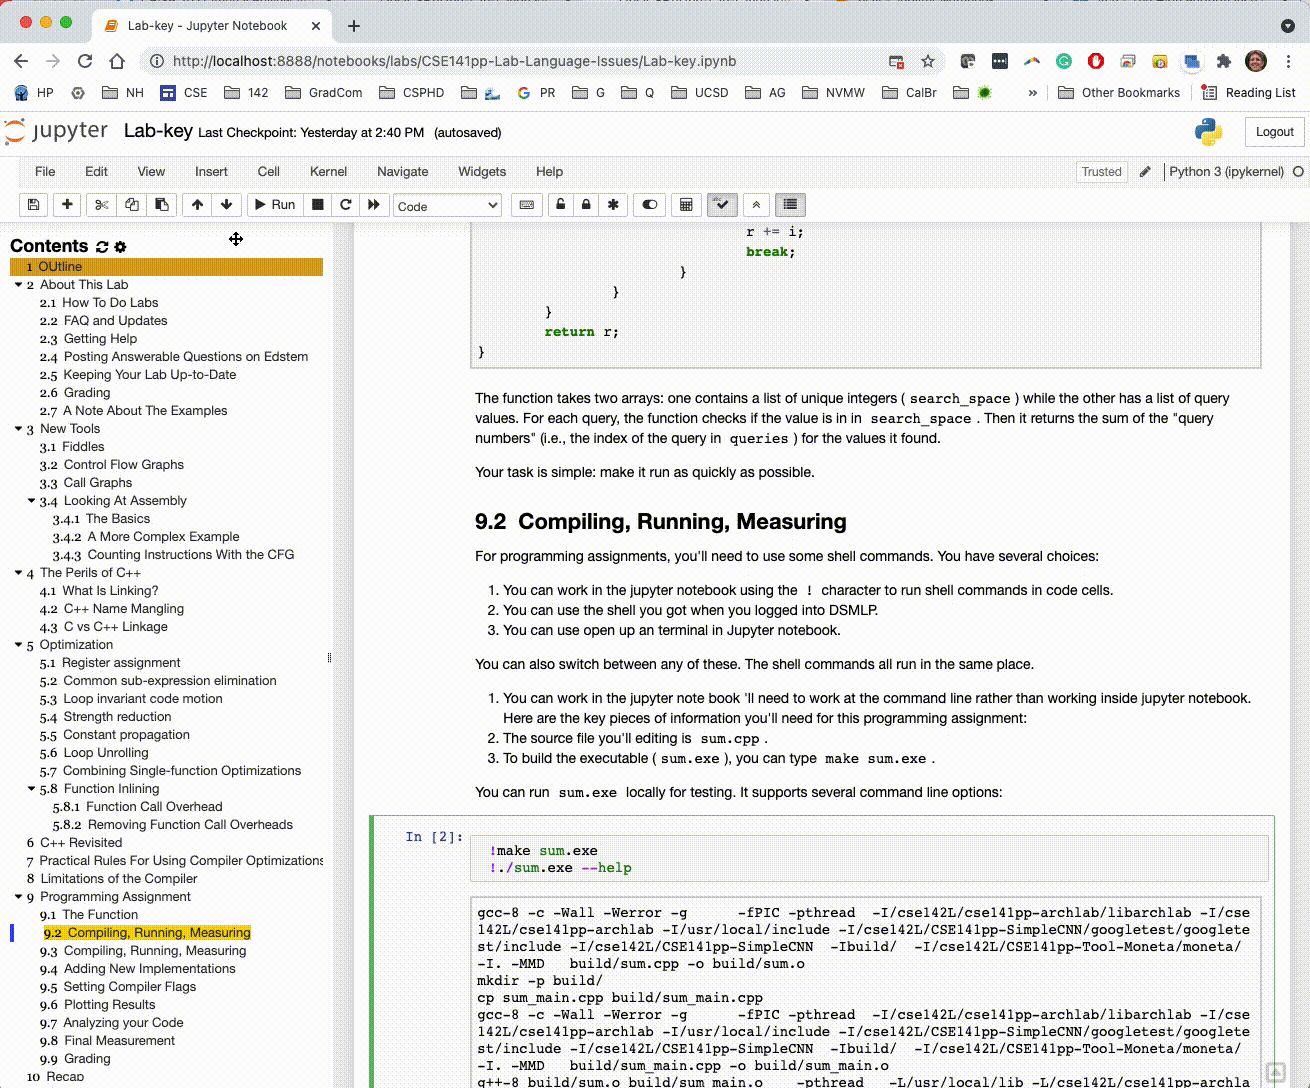

You can also switch between any of these.  The shell commands all run in the same directory structure.

Here are the key pieces of information you'll need for this programming assignment:

1.  The source file you'll editing is `sum.cpp`.
2.  To build the executable (`sum.exe`), you can type `make sum.exe`.

You can run `sum.exe` locally for testing.  It supports several command line options:

In [14]:
!make sum.exe
!./sum.exe --help

mkdir -p build/
cp sum.cpp build/sum.cpp 
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/sum.cpp -o build/sum.o
mkdir -p build/
cp sum_main.cpp build/sum_main.cpp 
gcc-8 -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD   build/sum_main.cpp -o build/sum_main.o
g++-8 build/sum.o build/sum_main.o    -pthread   -L/usr/local/lib -L/cse142L/cse141pp-archlab/libarchlab -larchlab -lpapi -lboost_program_options -lm -lquadmath -ldl    -o sum.exe
ArchLab driver:
  --MHz arg (=-1)                       Which clock rate to run.  

The ones you should be concerned with are:

* `--function` which will let you select an implementation to test.
* `--stats` which controls where your data goes.
* `--space-size` controls the search space size.
* `--queries` controls how many queries to run.

You can measure performance in the cloud with this command line (Note, I've set `--MHz 3500`.  The default is 3501, but that will enable TurboBoost and make our performance unpredictable):

In [15]:
!make sum.exe
!cse142 job run --take sum.exe --take PE.cfg --take config.make "./sum.exe --function sum_of_locations sum_of_locations_solution  --MHz 3500 --space-size 500000 --stats benchmark.csv --stat-set PE.cfg"

make: 'sum.exe' is up to date.
You are submitting a job for lab "Lab 2: The Compiler" (compiler).
Creating job 234b482d-575e-4464-a641-393e2fbf93ae 0.00 0.00
Ready for submission. 3.31 3.31
Job 234b482d-575e-4464-a641-393e2fbf93ae is in state 'PUBLISHED'. 0.51 3.82. 
Job 234b482d-575e-4464-a641-393e2fbf93ae is in state 'RUNNING'. 2.11 5.93.. 
Job 234b482d-575e-4464-a641-393e2fbf93ae is in state 'DONE_RUNNING'. 3.16 9.09... 
Job 234b482d-575e-4464-a641-393e2fbf93ae succeeded. 4.19 13.28Writing results 1.00 14.28
Loading PAPI engine.
Tracking PAPI_TOT_INS
Tracking PAPI_TOT_CYC
0
0
Updated these files: ./benchmark.csv
./benchmark.csv.raw
Job Complete 0.50 14.78


Here are the details on what those options mean:

* `--take sum.exe --take PE.cfg` This let's the tool know that it only needs to copy these two file to server in the cloud to run your job.
* `--stats benchmark.csv` puts the results in that `csv` file.
* `--stat-set PE.cfg` collects `IC`, `CPI`, `CT`, and `ET` data.
* `--seed` sets the random seed.
* `--function ALL` will run all the implementations in `sum.cpp`.  You enter a subset if you want.

If you run the command on your starter code right after you check it out, it'll produce a `csv` file called `benchmark.csv` with two lines:

In [16]:
display(render_csv("benchmark.csv"))

space_size  query_count  seed  result  cmdlineMHz  \
0      500000         1024     1  259932        3500   
1      500000         1024     1  259932        3500   

                    function  rep          IC        ET      cycles  \
0           sum_of_locations    0  6562093777  0.866472  3019198084   
1  sum_of_locations_solution    0  6562093930  0.867916  3024273384   

             CT       CPI   ET_calc      realMHz  Unnamed: 14  
0  2.869874e-10  0.460097  0.866472  3484.473089          NaN  
1  2.869833e-10  0.460870  0.867916  3484.523516          NaN

The output of the program is in `result` and the execution time is in `ET`.

You can print the CSV file nicely at the command line:

In [17]:
!pretty-csv benchmark.csv

space_size|query_count|seed|result |cmdlineMHz|function                 |rep|IC      |ET   |cycles  |CT      |CPI  |ET_calc|realMHz |
----------|-----------|----|-------|----------|-------------------------|---|--------|-----|--------|--------|-----|-------|--------|
5e+05     |1.02e+03   |1.0 |2.6e+05|3.5e+03   |sum_of_locations         |0.0|6.56e+09|0.866|3.02e+09|2.87e-10|0.46 |0.866  |3.48e+03|
5e+05     |1.02e+03   |1.0 |2.6e+05|3.5e+03   |sum_of_locations_solution|0.0|6.56e+09|0.868|3.02e+09|2.87e-10|0.461|0.868  |3.48e+03|


## Adding New Implementations

The starter code for `sum.cpp` has two solutions in it:  `sum_of_locations()` and `sum_of_locations_solution()`.  `sum_of_locations_solution()` should eventually contain your best implementation, and that's what we will grade.  You can add as many other implementations as you'd like.  To do so, just create a new function with a new name (e.g., `sum_of_locations_new_version`) but same arguments and return value.  Then add this immediately after the end of the function:

```
FUNCTION("sum_impl", sum_of_locations_new_version);
```

That will allow you to pass `--function sum_of_locations_new_version` to test your new version.


## Setting Compiler Flags

If you'd like, you can set compilation flags in `config.make`.  Here's the initial contents:

In [19]:
render_code("config.make")

// config.make:1-2 (2 lines)
SUM_OPTIMIZE=

It will compile your code with no optimizations.

To edit `config.make`, you can open up a terminal and edit it with `emacs`, `vim`, or `pico`.

## Potentially Useful Tools

### Plotting Results

If you want to analyze the data from your experiments, you can either:

1.  Copy the contents of the csv file into Excel or Google sheets.
2.  Use [Pandas](https://pandas.pydata.org/) and [matplotlib](https://matplotlib.org/).

You can get a Pandas dataframe like so. 

In [20]:
df = render_csv("benchmark.csv")

Pandas and matplotlib are very powerful (they are what I use to draw all the graphs in the labs) but also complex.  Learning/using them is not necessary for this class.  The utility functions I use in the labs is in `notebook.py` in your repo.  You can look there, if you are interested.

One simple trick to get a bar graph of the performance of all your implementations:

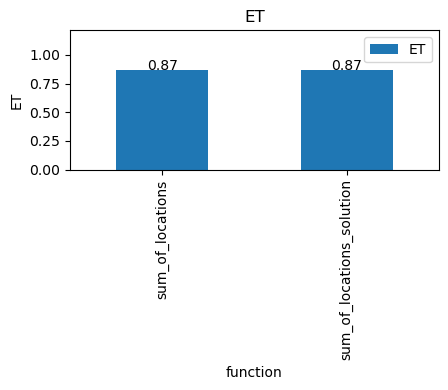

In [21]:
plotPEBar("benchmark.csv", what=[("function", "ET")])

### Analyzing your Code

If you want to look at the CFG for your code, use the fiddle below.

Compiling your code...
make sum.exe build/sum.s
make: 'sum.exe' is up to date.
g++-8 -S -c -Wall -Werror -g      -fPIC -pthread  -I/cse142L/cse141pp-archlab/libarchlab -I/cse142L/cse141pp-archlab -I/usr/local/include -I/cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I/cse142L/CSE141pp-SimpleCNN  -Ibuild/  -I/cse142L/CSE141pp-Tool-Moneta/moneta/  -I. -MMD  -std=gnu++11   -g0 build/sum.cpp -o build/sum.s



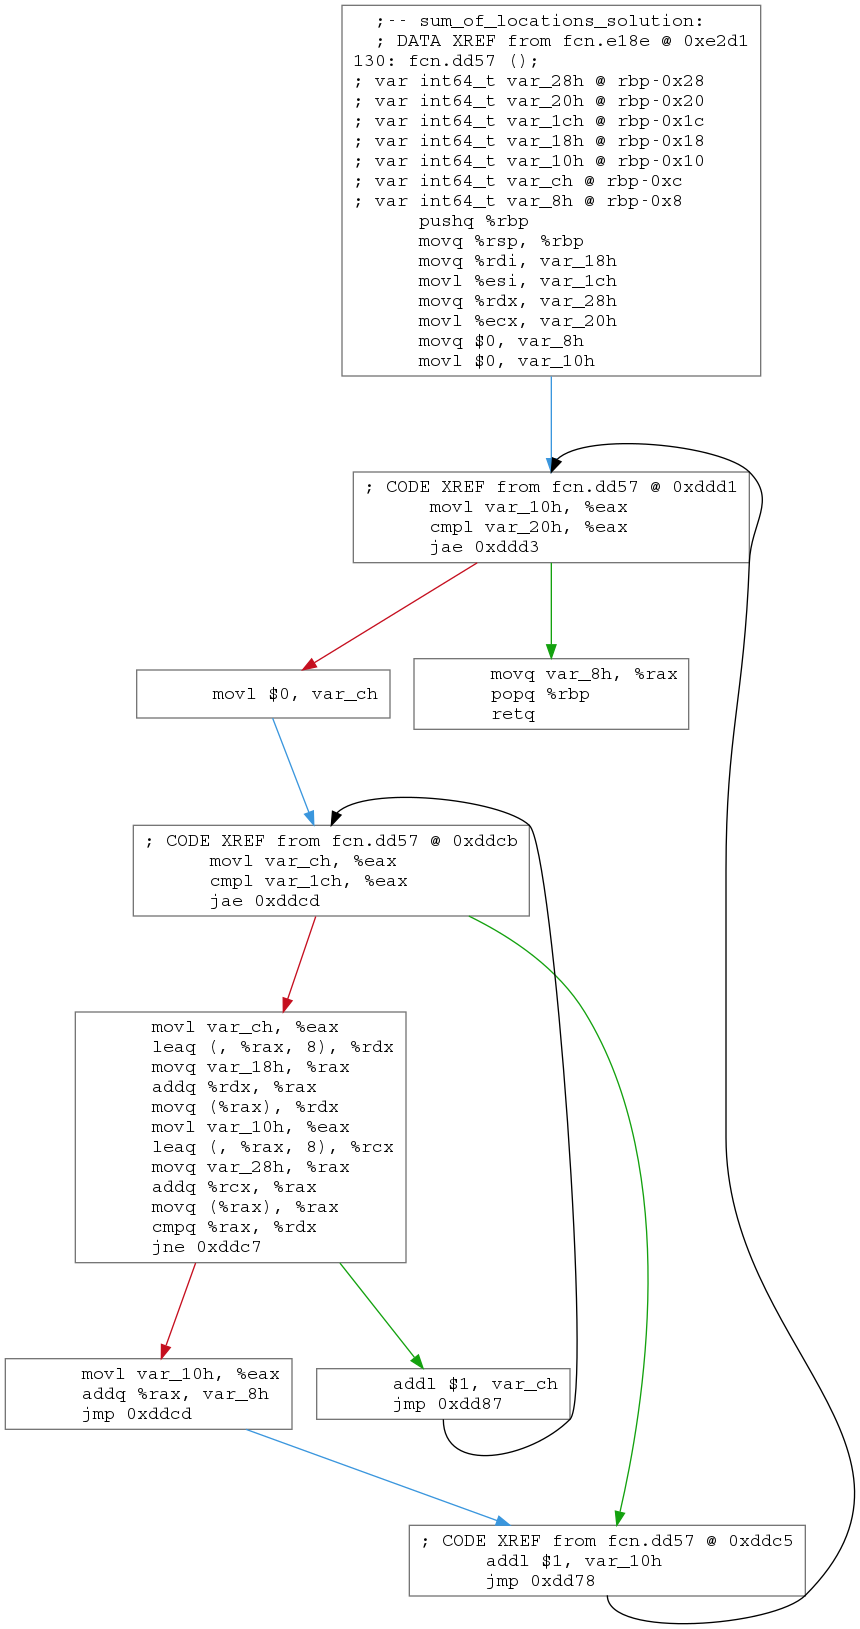

In [22]:
f = fiddle("sum.cpp", function="sum_of_locations_solution", build_cmd="make sum.exe build/sum.s", run=False, gprof=False, trim_addresses=True)
# display(f.asm) # uncomment to display the assembly.
display(f.cfg) # uncomment to display the cfg
# display(f.source) # uncomment to display the source


## Final Measurement

When you are done, make sure your best solution is named `sum_of_locations_solution()` in `sum.cpp`.  Then you can submit your code to the Gradescope autograder.  It will run the command given above and use the `ET` and `result` values from `benchmark.csv` to assign your grade.

You can mimic exactly what the autograder will do with this command:

In [23]:
!cse142 job run --take sum.exe --take PE.cfg --take config.make --lab compiler-bench benchmark

You are submitting a job for lab "Lab 2: The Compiler (Benchmark)" (compiler-bench).
You are running a autograde job.  Here's what will get run:
  git clone --branch main https://github.com/CSE142/fa21-CSE142L-compiler-starter.git autograde
  make -C autograde copy-files benchmark
The outputs will appear in the 'autograde' directory.  Check STUDENT_EDITABLE_FILES in Makefile to see what source files will be copied over.
Creating job a3a840f2-0b7f-469d-a411-ce95819f4021 0.00 0.00
Ready for submission. 3.04 3.04
Job a3a840f2-0b7f-469d-a411-ce95819f4021 is in state 'PUBLISHED'. 0.52 3.56 
Job a3a840f2-0b7f-469d-a411-ce95819f4021 is in state 'SCHEDULED'. 1.04 4.60 
Job a3a840f2-0b7f-469d-a411-ce95819f4021 is in state 'RUNNING'. 1.05 5.65 
Job a3a840f2-0b7f-469d-a411-ce95819f4021 failed after running 0:00:01.092870 seconds on sjswanson-23697 1.04 6.69Error: Your Job failed:
512, in run
    output=stdout, stderr=stderr)
subprocess.CalledProcessError: Command '['git', 'clone', '--branch', 'ma

In [ ]:
display(render_csv("benchmark/benchmark.csv"))


And you can find the results in `benchmark/benchmark.csv` rather than `./benchmark.csv`.  The difference between this command and the "normal' command given above is that this command:

1.  Ignores all the files in your repo except `sum.cpp` and `config.make`.
2.  Copies those files into a clean clone of the starter repo.
3.  Builds `sum.exe` from scratch.
4.  And then runs the command above with `--function sum_of_locations_solution`.


## Grading 

Your grade is based on your speed up relative to the original version of `sum_of_locations()`.

# Recap

This lab has illustrated a range of common compiler optimizations that improve program performance.  We've seen how optimizations can work in isolation and, often more important, how one optimization (I'm looking at you, inlining) can often unlock additional opportunities to apply further optimizations.  We've also seen how optimizations are especially important for C++ and other languages where small functions are common.  Finally, we quantified the impact of optimizations using the performance equation.



#KEY include Turnin.ipynb